# Contextual models evaluation

## Environment preparation

### Imports

In [1]:
import os
from datetime import datetime

In [2]:
from tqdm import tqdm

In [3]:
from itertools import product

In [4]:
from joblib import Parallel, delayed, parallel_backend

In [5]:
import numpy as np

In [6]:
from scipy.stats import pearsonr, spearmanr
from scipy.special import softmax

In [7]:
import pandas as pd

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

In [10]:
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, roc_auc_score

In [11]:
from vstk.models import Word2Vec, GloVe, FastText, Def2Vec, Def2VecLegacy

/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
from vstk.data import CoNLL2003, SST, STS, NewsGroups, WELFake

### Constants

In [13]:
W2V_MODEL_PATH = '../resources/models/pre_trained/word_2_vec/'
GV_MODEL_PATH = '../resources/models/pre_trained/glove/'
FT_MODEL_PATH = '../resources/models/pre_trained/fast_text/'
D2V_LEGACY_MODEL_PATH = '../resources/models/pre_trained/def_2_vec_legacy/'
# Sub-words
# D2V_MODEL_PATH = '../resources/models/pre_trained/def_2_vec_084926b712881ac5c62a5c520898bc8a20d2df205cd3fafbfe8fb66060294291/'
# Sub-words - Stop-words removed
# D2V_MODEL_PATH = '../resources/models/pre_trained/def_2_vec_2528fc7769d477bed290bfa827d5b499b0849a7e1851cbfdc37e296e21373071/'  # Main model
# D2V_MODEL_PATH = '../resources/models/pre_trained/def_2_vec_2528fc7769d477bed290bfa827d5b499b0849a7e1851cbfdc37e296e21373071_extended/'
# D2V_MODEL_PATH = '../resources/models/pre_trained/def_2_vec_2528fc7769d477bed290bfa827d5b499b0849a7e1851cbfdc37e296e21373071_reduced/'
# No sub-words
# D2V_MODEL_PATH = '../resources/models/pre_trained/def_2_vec_6a9f23276b7f235c3ef6aa8facb0efee6f716bd7ce8387e01c8df27831f35b27/'
# No sub-words - Stop-words removed
# D2V_MODEL_PATH = '../resources/models/pre_trained/def_2_vec_85d911ac6e585a5f6d1abbdb40609fb024d8d67d24c5f14a9b8da1eca6d8f863/'

In [14]:
CONLL2003_DATA_PATH = '../resources/data/raw/conll2003'
SST_DATA_PATH = '../resources/data/raw/stanfordSentimentTreebank'
STS_DATA_PATH = '../resources/data/raw/stsbenchmark'
WELFAKE_DATA_PATH = '../resources/data/raw/WELFake'

In [15]:
CLS_METRICS = [
    'accuracy', 
    'precision (macro)', 
    'recall (macro)', 
    'fscore (macro)', 
    'auc (macro)', 
    'precision (weighted)', 
    'recall (weighted)', 
    'fscore (weighted)', 
    'auc (weighted)',
    'accuracy (sample weight)', 
    'precision (sample weight)', 
    'recall (sample weight)', 
    'fscore (sample weight)', 
    'auc (sample weight)', 
]
REG_METRICS = [
    'pearson corr.',
    'pearson corr. p',
    'spearman corr.',
    'spearman corr. p'
]

In [16]:
if not os.path.exists('../experiments/'):
    os.mkdir('../experiments/')
if not os.path.exists('../experiments/contextual'):
    os.mkdir('../experiments/contextual')
RESULTS_FILE_PATH = f'../experiments/contextual/results.csv'  # 'results_{datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}.csv'

### Global

In [17]:
timestamp = datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

In [18]:
embeddings_model_dtype = GloVe
embeddings_model_path = GV_MODEL_PATH

In [19]:
model_id = os.path.basename(os.path.split(embeddings_model_path)[0])
model_id

'glove'

In [20]:
embeddings_model = embeddings_model_dtype.load(embeddings_model_path)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [22]:
conll = {split: CoNLL2003(CONLL2003_DATA_PATH, split=split) for split in ['train', 'validation', 'test']}
sst = {split: SST(SST_DATA_PATH, split=split, binary=True) for split in ['train', 'validation', 'test']}
sts = {split: STS(STS_DATA_PATH, split=split) for split in ['train', 'validation', 'test']}
ng = {split: NewsGroups(split=split) for split in ['train', 'validation', 'test']}
welfake = {split: WELFake(WELFAKE_DATA_PATH, split=split) for split in ['train', 'validation', 'test']}

In [23]:
results = list()

## Experiments

### CoNLL 2003

Evaluate on token classification

In [24]:
corpus = 'CoNLL-2003'

In [ ]:
conll['train']._data[:3]

In [ ]:
class TokenClassification(nn.Module):
    def __init__(self, input_size, output_size, hidden_size: int = 512, kernel_size: int = 5):
        super().__init__()
        self.norm = nn.LayerNorm(input_size)
        self.conv1d = nn.Conv1d(input_size, hidden_size, kernel_size, padding='same', bias=False)
        self.dropout = nn.Dropout(0.1)
        self.cls_head = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # 
        x = self.dropout(x)
        #
        h = self.conv1d(x.transpose(-1, -2))  # self.norm(x).transpose(-1, -2)
        # Non-linear activation
        h = F.gelu(h)
        # Dropout
        h = self.dropout(h)
        # Apply last linear projection
        y = self.cls_head(h.transpose(-1, -2))

        return y


In [ ]:
le = conll['train'].get_label_transformer()
for label, le_ in le.items():
    print(label, le_.classes_)

In [ ]:
lw = {label: lw_.to(device) for label, lw_ in conll['train'].get_label_weights().items()}
for label, lw_ in lw.items():
    print(label, lw_)

#### POS tagging

In [ ]:
task = 'pos'

In [ ]:
model = TokenClassification(300, len(le[task].classes_))  # 300, 300, *, 3
model = model.to(device)
model

In [ ]:
lr = 0.001  # 0.0005
batch_size = 512  # 128
n_epochs = 64  # 10
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)

In [ ]:
def collate(mini_batch):
    # Get the length of the longest sentence
    max_sequence_len = max(len(sample) for sample in mini_batch)
    # Create an input tensor with all zero values
    input_embeds = np.zeros((len(mini_batch), max_sequence_len, 300))
    #
    valid_mask = np.zeros((len(mini_batch), max_sequence_len))
    # Create a target output matrix with all -100 (PyTorch ignores this value by default)
    output_lbl = np.full((len(mini_batch), max_sequence_len), -100)
    # Fill the tensor and the matrix
    for i, sample in enumerate(mini_batch):
        for j, token in enumerate(sample):
            # Manage missing tokens in vocabulary
            input_embeds[i, j] = embeddings_model[token['token'].lower()]
            output_lbl[i, j] = le[task].transform([token[task]])[0]
        valid_mask[i, :len(sample)] = 1.0
    # Convert to PyTorch tensor
    input_embeds = torch.tensor(input_embeds, dtype=torch.float, device=device)
    valid_mask = torch.tensor(valid_mask, dtype=torch.float, device=device)
    output_lbl = torch.tensor(output_lbl, device=device)

    return input_embeds, output_lbl
    # return input_embeds, valid_mask, output_lbl

In [ ]:
data_loader = {
    split: torch.utils.data.DataLoader(
        data, batch_size=batch_size, collate_fn=collate, shuffle=split == 'train'
    )
    for split, data in conll.items()
}

##### Training

In [ ]:
path = os.path.join('../experiments/contextual/', f'{model_id}_{corpus}_{task}_{datetime.now()}.ckpt')

# Set model in training mode
model.train()

# Accumulator of loss
history = []
validation_history = []
best_validation_loss = torch.tensor(float('inf'), device=device)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, steps_per_epoch=len(data_loader['train']), epochs=n_epochs, anneal_strategy='linear', pct_start=0.05)

estop_counter = 0

# Iterate over epochs
for i in range(n_epochs):
    print(f"Starting epoch {i + 1}/{n_epochs}")
    # Iterate over training batches
    # for embeds, lbl in tqdm(data_loader['train']):
    for embeds, lbl in tqdm(data_loader['train']):
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Move input and output to target device
        embeds = embeds.to(device)
        lbl = lbl.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds)
        # Flatten logits to a shape (batch_size * max_sentence_len, n_classes)
        logits = logits.reshape(-1, len(le[task].classes_))
        # Flatten targets to a shape (batch_size * max_sentence_len)
        lbl = lbl.reshape(-1)
        # Compute loss
        loss = F.cross_entropy(logits, lbl)
        # Compute gradients
        loss.backward()
        # Update weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        # scheduler.step()
        # Save loss
        history.append(loss.detach())
    # Disable gradients
    with torch.no_grad():
        print(f"Starting validation epoch {i + 1}/{n_epochs}")
        # Set in evaluation mode
        model.eval()
        # Init validation loss accumulator
        loss = []
        # Iterate over validation batches
        for embeds, lbl in tqdm(data_loader['validation']):
            # Move input and output to target device
            embeds = embeds.to(device)
            lbl = lbl.to(device)
            # Compute logits (i.e., softmax values before exponential normalisation)
            logits = model(embeds)
            # Flatten logits to a shape (batch_size * max_sentence_len, n_classes)
            logits = logits.reshape(-1, len(le[task].classes_))
            # Flatten targets to a shape (batch_size * max_sentence_len)
            lbl = lbl.reshape(-1)
            # Compute loss
            loss.append(F.cross_entropy(logits, lbl))
        # Aggregate validation loss
        validation_history.append(torch.tensor(loss, device=device).mean())
        # Check if validation loss has improved
        if validation_history[-1] <= best_validation_loss:
            torch.save(model.state_dict(), path)
            best_validation_loss = validation_history[-1]
            estop_counter = 0
        else:
            estop_counter += 1
        # Restore training mode
        model.train()
    if estop_counter >= 5:
        break
        
# Restore best weights
if os.path.exists(path):
    model.load_state_dict(torch.load(path))

history = [loss.cpu().item() for loss in history]
validation_history = [loss.cpu().item() for loss in validation_history]

In [ ]:
plt.figure()
plt.plot(range(len(history)), history, label='Training loss')
plt.plot(range(len(data_loader['train']) - 1, len(history), len(data_loader['train'])), validation_history, label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Update step')
plt.ylabel('Loss')
plt.xlim([0.0, len(history)])
plt.ylim([0.0, 4.0])
plt.grid()

##### Evaluation

In [ ]:
# Set model in evaluation mode
model.eval()

Validation set

In [ ]:
#
split = 'validation'

# Accumulators for target labels and predictions
y_true = []
y_pred = []
y_proba = []

# Disable gradients
with torch.no_grad():
    # Iterate over validation batches
    for embeds, lbl in tqdm(data_loader[split]):
        # Move input and output to target device
        embeds = embeds.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds)
        # Get predictions as the index corresponding to the highest logit score
        pred_lbl = torch.argmax(logits, dim=-1)
        # Append predicted proba
        y_proba.append(logits.view(-1, len(le[task].classes_)).cpu().numpy())
        # Append predicted labels
        y_pred.append(pred_lbl.view(-1).cpu().numpy())
        # Append target labels
        y_true.append(lbl.view(-1).cpu().numpy())

# Concatenate all the vectors of target labels and predicted labels
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_proba = np.concatenate(y_proba, axis=0)
# Remove elements to ignore (the -100 labels)
mask = y_true == -100
y_true = y_true[~mask]
y_pred = y_pred[~mask]
y_proba = y_proba[~mask]

labels = np.unique(y_true)
mapping = np.zeros(len(le[task].classes_), dtype=int)
mapping[labels] = np.arange(len(labels))

y_true = mapping[y_true]
y_pred = mapping[y_pred]
y_proba = softmax(y_proba[:, labels], axis=1)

ids, counts = np.unique(y_true, return_counts=True)
weights = counts / np.sum(counts)

# 
accuracy = accuracy_score(y_true, y_pred)
precision_m, recall_m, fscore_m, support_m = precision_recall_fscore_support(y_true, y_pred, average='macro')
auc_m = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
precision_w, recall_w, fscore_w, support_w = precision_recall_fscore_support(y_true, y_pred, average='weighted')
auc_w = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
accuracy_sw = accuracy_score(y_true, y_pred, sample_weight=weights[y_true])
precision_sw, recall_sw, fscore_sw, support_sw = precision_recall_fscore_support(y_true, y_pred, average='weighted', sample_weight=weights[y_true])
auc_sw = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted', sample_weight=weights[y_true])
results.extend([
    {
        'corpus': corpus,
        'task': task,
        'embeddings': model_id,
        'split': split,
        'timestamp': timestamp,
        'metric': metric,
        'value': value
    }
    for metric, value in zip(
        CLS_METRICS, [
            accuracy, precision_m, recall_m, fscore_m, auc_m, 
            precision_w, recall_w, fscore_w, auc_w,
            accuracy_sw, precision_sw, recall_sw, fscore_sw, auc_sw
        ]
    )
])
# Finally compute classification report
print()
print(classification_report(y_true, y_pred, target_names=le[task].classes_[labels]))

Test set

In [ ]:
#
split = 'test'

# Accumulators for target labels and predictions
y_true = []
y_pred = []
y_proba = []

# Disable gradients
with torch.no_grad():
    # Iterate over validation batches
    for embeds, lbl in tqdm(data_loader[split]):
        # Move input and output to target device
        embeds = embeds.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds)
        # Get predictions as the index corresponding to the highest logit score
        pred_lbl = torch.argmax(logits, dim=-1)
        # Append predicted proba
        y_proba.append(logits.view(-1, len(le[task].classes_)).cpu().numpy())
        # Append predicted labels
        y_pred.append(pred_lbl.view(-1).cpu().numpy())
        # Append target labels
        y_true.append(lbl.view(-1).cpu().numpy())

# Concatenate all the vectors of target labels and predicted labels
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_proba = np.concatenate(y_proba, axis=0)
# Remove elements to ignore (the -100 labels)
mask = y_true == -100
y_true = y_true[~mask]
y_pred = y_pred[~mask]
y_proba = y_proba[~mask]

labels = np.unique(y_true)
mapping = np.zeros(len(le[task].classes_), dtype=int)
mapping[labels] = np.arange(len(labels))

y_true = mapping[y_true]
y_pred = mapping[y_pred]
y_proba = softmax(y_proba[:, labels], axis=1)

ids, counts = np.unique(y_true, return_counts=True)
weights = counts / np.sum(counts)

# 
accuracy = accuracy_score(y_true, y_pred)
precision_m, recall_m, fscore_m, support_m = precision_recall_fscore_support(y_true, y_pred, average='macro')
auc_m = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
precision_w, recall_w, fscore_w, support_w = precision_recall_fscore_support(y_true, y_pred, average='weighted')
auc_w = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
accuracy_sw = accuracy_score(y_true, y_pred, sample_weight=weights[y_true])
precision_sw, recall_sw, fscore_sw, support_sw = precision_recall_fscore_support(y_true, y_pred, average='weighted', sample_weight=weights[y_true])
auc_sw = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted', sample_weight=weights[y_true])
results.extend([
    {
        'corpus': corpus,
        'task': task,
        'embeddings': model_id,
        'split': split,
        'timestamp': timestamp,
        'metric': metric,
        'value': value
    }
    for metric, value in zip(
        CLS_METRICS, [
            accuracy, precision_m, recall_m, fscore_m, auc_m, 
            precision_w, recall_w, fscore_w, auc_w,
            accuracy_sw, precision_sw, recall_sw, fscore_sw, auc_sw
        ]
    )
])
# Finally compute classification report
print()
print(classification_report(y_true, y_pred, target_names=le[task].classes_[labels]))

#### Chunking

In [ ]:
task = 'chunk'

In [ ]:
model = TokenClassification(300, len(le[task].classes_))  # 300, 300, *, 3
model = model.to(device)
model

In [ ]:
lr = 0.001  # 0.0005
batch_size = 512  # 128
n_epochs = 64  # 10
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(params=model.parameters(), lr=lr)

In [ ]:
def collate(mini_batch):
    # Get the length of the longest sentence
    max_sequence_len = max(len(sample) for sample in mini_batch)
    # Create an input tensor with all zero values
    input_embeds = np.zeros((len(mini_batch), max_sequence_len, 300))
    #
    valid_mask = np.zeros((len(mini_batch), max_sequence_len))
    # Create a target output matrix with all -100 (PyTorch ignores this value by default)
    output_lbl = np.full((len(mini_batch), max_sequence_len), -100)
    # Fill the tensor and the matrix
    for i, sample in enumerate(mini_batch):
        for j, token in enumerate(sample):
            # Manage missing tokens in vocabulary
            input_embeds[i, j] = embeddings_model[token['token'].lower()]
            try:
                output_lbl[i, j] = le[task].transform([token[task]])[0]
            except ValueError:
                pass
        valid_mask[i, :len(sample)] = 1.0
    # Convert to PyTorch tensor
    input_embeds = torch.tensor(input_embeds, dtype=torch.float, device=device)
    valid_mask = torch.tensor(valid_mask, dtype=torch.float, device=device)
    output_lbl = torch.tensor(output_lbl, device=device)

    return input_embeds, output_lbl
    # return input_embeds, valid_mask, output_lbl

In [ ]:
data_loader = {
    split: torch.utils.data.DataLoader(
        data, batch_size=batch_size, collate_fn=collate, shuffle=split == 'train'
    )
    for split, data in conll.items()
}

##### Training

In [ ]:
path = os.path.join('../experiments/contextual/', f'{model_id}_{corpus}_{task}_{datetime.now()}.ckpt')

# Set model in training mode
model.train()

# Accumulator of loss
history = []
validation_history = []
best_validation_loss = torch.tensor(float('inf'), device=device)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, steps_per_epoch=len(data_loader['train']), epochs=n_epochs, anneal_strategy='linear', pct_start=0.05)

estop_counter = 0

# Iterate over epochs
for i in range(n_epochs):
    print(f"Starting epoch {i + 1}/{n_epochs}")
    # Iterate over training batches
    for embeds, lbl in tqdm(data_loader['train']):
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Move input and output to target device
        embeds = embeds.to(device)
        lbl = lbl.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds)
        # Flatten logits to a shape (batch_size * max_sentence_len, n_classes)
        logits = logits.reshape(-1, len(le[task].classes_))
        # Flatten targets to a shape (batch_size * max_sentence_len)
        lbl = lbl.reshape(-1)
        # Compute loss
        loss = F.cross_entropy(logits, lbl)
        # Compute gradients
        loss.backward()
        # Update weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        # scheduler.step()
        # Save loss
        history.append(loss.detach())
    # Disable gradients
    with torch.no_grad():
        print(f"Starting validation epoch {i + 1}/{n_epochs}")
        # Set in evaluation mode
        model.eval()
        # Init validation loss accumulator
        loss = []
        # Iterate over validation batches
        for embeds, lbl in tqdm(data_loader['validation']):
            # Move input and output to target device
            embeds = embeds.to(device)
            lbl = lbl.to(device)
            # Compute logits (i.e., softmax values before exponential normalisation)
            logits = model(embeds)
            # Flatten logits to a shape (batch_size * max_sentence_len, n_classes)
            logits = logits.reshape(-1, len(le[task].classes_))
            # Flatten targets to a shape (batch_size * max_sentence_len)
            lbl = lbl.reshape(-1)
            # Compute loss
            loss.append(F.cross_entropy(logits, lbl))
        # Aggregate validation loss
        validation_history.append(torch.tensor(loss, device=device).mean())
        # Check if validation loss has improved
        if validation_history[-1] <= best_validation_loss:
            torch.save(model.state_dict(), path)
            best_validation_loss = validation_history[-1]
            estop_counter = 0
        else:
            estop_counter += 1
        # Restore training mode
        model.train()
    if estop_counter >= 5:
        break
        
# Restore best weights
if os.path.exists(path):
    model.load_state_dict(torch.load(path))

history = [loss.cpu().item() for loss in history]
validation_history = [loss.cpu().item() for loss in validation_history]

In [ ]:
plt.figure()
plt.plot(range(len(history)), history, label='Training loss')
plt.plot(range(len(data_loader['train']) - 1, len(history), len(data_loader['train'])), validation_history, label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Update step')
plt.ylabel('Loss')
plt.xlim([0.0, len(history)])
plt.ylim([0.0, 4.0])
plt.grid()

##### Evaluation

In [ ]:
# Set model in evaluation mode
model.eval()

Validation set

In [ ]:
#
split = 'validation'

# Accumulators for target labels and predictions
y_true = []
y_pred = []
y_proba = []

# Disable gradients
with torch.no_grad():
    # Iterate over validation batches
    for embeds, lbl in tqdm(data_loader[split]):
        # Move input and output to target device
        embeds = embeds.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds)
        # Get predictions as the index corresponding to the highest logit score
        pred_lbl = torch.argmax(logits, dim=-1)
        # Append predicted proba
        y_proba.append(logits.view(-1, len(le[task].classes_)).cpu().numpy())
        # Append predicted labels
        y_pred.append(pred_lbl.view(-1).cpu().numpy())
        # Append target labels
        y_true.append(lbl.view(-1).cpu().numpy())

# Concatenate all the vectors of target labels and predicted labels
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_proba = np.concatenate(y_proba, axis=0)
# Remove elements to ignore (the -100 labels)
mask = y_true == -100
y_true = y_true[~mask]
y_pred = y_pred[~mask]
y_proba = y_proba[~mask]

labels = np.unique(y_true)
mapping = np.zeros(len(le[task].classes_), dtype=int)
mapping[labels] = np.arange(len(labels))

y_true = mapping[y_true]
y_pred = mapping[y_pred]
y_proba = softmax(y_proba[:, labels], axis=1)

ids, counts = np.unique(y_true, return_counts=True)
weights = counts / np.sum(counts)

# 
accuracy = accuracy_score(y_true, y_pred)
precision_m, recall_m, fscore_m, support_m = precision_recall_fscore_support(y_true, y_pred, average='macro')
auc_m = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
precision_w, recall_w, fscore_w, support_w = precision_recall_fscore_support(y_true, y_pred, average='weighted')
auc_w = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
accuracy_sw = accuracy_score(y_true, y_pred, sample_weight=weights[y_true])
precision_sw, recall_sw, fscore_sw, support_sw = precision_recall_fscore_support(y_true, y_pred, average='weighted', sample_weight=weights[y_true])
auc_sw = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted', sample_weight=weights[y_true])
results.extend([
    {
        'corpus': corpus,
        'task': task,
        'embeddings': model_id,
        'split': split,
        'timestamp': timestamp,
        'metric': metric,
        'value': value
    }
    for metric, value in zip(
        CLS_METRICS, [
            accuracy, precision_m, recall_m, fscore_m, auc_m, 
            precision_w, recall_w, fscore_w, auc_w,
            accuracy_sw, precision_sw, recall_sw, fscore_sw, auc_sw
        ]
    )
])
# Finally compute classification report
print()
print(classification_report(y_true, y_pred, target_names=le[task].classes_[labels]))

Test set

In [ ]:
#
split = 'test'

# Accumulators for target labels and predictions
y_true = []
y_pred = []
y_proba = []

# Disable gradients
with torch.no_grad():
    # Iterate over validation batches
    for embeds, lbl in tqdm(data_loader[split]):
        # Move input and output to target device
        embeds = embeds.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds)
        # Get predictions as the index corresponding to the highest logit score
        pred_lbl = torch.argmax(logits, dim=-1)
        # Append predicted proba
        y_proba.append(logits.view(-1, len(le[task].classes_)).cpu().numpy())
        # Append predicted labels
        y_pred.append(pred_lbl.view(-1).cpu().numpy())
        # Append target labels
        y_true.append(lbl.view(-1).cpu().numpy())

# Concatenate all the vectors of target labels and predicted labels
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_proba = np.concatenate(y_proba, axis=0)
# Remove elements to ignore (the -100 labels)
mask = y_true == -100
y_true = y_true[~mask]
y_pred = y_pred[~mask]
y_proba = y_proba[~mask]

labels = np.unique(y_true)
mapping = np.zeros(len(le[task].classes_), dtype=int)
mapping[labels] = np.arange(len(labels))

y_true = mapping[y_true]
y_pred = mapping[y_pred]
y_proba = softmax(y_proba[:, labels], axis=1)

ids, counts = np.unique(y_true, return_counts=True)
weights = counts / np.sum(counts)

# 
accuracy = accuracy_score(y_true, y_pred)
precision_m, recall_m, fscore_m, support_m = precision_recall_fscore_support(y_true, y_pred, average='macro')
auc_m = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
precision_w, recall_w, fscore_w, support_w = precision_recall_fscore_support(y_true, y_pred, average='weighted')
auc_w = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
accuracy_sw = accuracy_score(y_true, y_pred, sample_weight=weights[y_true])
precision_sw, recall_sw, fscore_sw, support_sw = precision_recall_fscore_support(y_true, y_pred, average='weighted', sample_weight=weights[y_true])
auc_sw = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted', sample_weight=weights[y_true])
results.extend([
    {
        'corpus': corpus,
        'task': task,
        'embeddings': model_id,
        'split': split,
        'timestamp': timestamp,
        'metric': metric,
        'value': value
    }
    for metric, value in zip(
        CLS_METRICS, [
            accuracy, precision_m, recall_m, fscore_m, auc_m, 
            precision_w, recall_w, fscore_w, auc_w,
            accuracy_sw, precision_sw, recall_sw, fscore_sw, auc_sw
        ]
    )
])
# Finally compute classification report
print()
print(classification_report(y_true, y_pred, target_names=le[task].classes_[labels]))

#### NER

In [ ]:
task = 'ner'

In [ ]:
model = TokenClassification(300, len(le[task].classes_))  # 300, 300, *, 3
model = model.to(device)
model

In [ ]:
lr = 0.001  # 0.0005
batch_size = 512  # 128
n_epochs = 64  # 10
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr)
# optimizer = torch.optim.RMSprop(params=model.parameters(), lr=lr)

In [ ]:
def collate(mini_batch):
    # Get the length of the longest sentence
    max_sequence_len = max(len(sample) for sample in mini_batch)
    # Create an input tensor with all zero values
    input_embeds = np.zeros((len(mini_batch), max_sequence_len, 300))
    #
    valid_mask = np.zeros((len(mini_batch), max_sequence_len))
    # Create a target output matrix with all -100 (PyTorch ignores this value by default)
    output_lbl = np.full((len(mini_batch), max_sequence_len), -100)
    # Fill the tensor and the matrix
    for i, sample in enumerate(mini_batch):
        for j, token in enumerate(sample):
            # Manage missing tokens in vocabulary
            input_embeds[i, j] = embeddings_model[token['token'].lower()]
            output_lbl[i, j] = le[task].transform([token[task]])[0]
        valid_mask[i, :len(sample)] = 1.0
    # Convert to PyTorch tensor
    input_embeds = torch.tensor(input_embeds, dtype=torch.float, device=device)
    valid_mask = torch.tensor(valid_mask, dtype=torch.float, device=device)
    output_lbl = torch.tensor(output_lbl, device=device)

    return input_embeds, output_lbl
    # return input_embeds, valid_mask, output_lbl

In [ ]:
data_loader = {
    split: torch.utils.data.DataLoader(
        data, batch_size=batch_size, collate_fn=collate, shuffle=split == 'train'
    )
    for split, data in conll.items()
}

##### Training

In [ ]:
path = os.path.join('../experiments/contextual/', f'{model_id}_{corpus}_{task}_{datetime.now()}.ckpt')

# Set model in training mode
model.train()

# Accumulator of loss
history = []
validation_history = []
best_validation_loss = torch.tensor(float('inf'), device=device)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, steps_per_epoch=len(data_loader['train']), epochs=n_epochs, anneal_strategy='linear', pct_start=0.05)

estop_counter = 0

# Iterate over epochs
for i in range(n_epochs):
    print(f"Starting epoch {i + 1}/{n_epochs}")
    # Iterate over training batches
    for embeds, lbl in tqdm(data_loader['train']):
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Move input and output to target device
        embeds = embeds.to(device)
        lbl = lbl.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds)
        # Flatten logits to a shape (batch_size * max_sentence_len, n_classes)
        logits = logits.reshape(-1, len(le[task].classes_))
        # Flatten targets to a shape (batch_size * max_sentence_len)
        lbl = lbl.reshape(-1)
        # Compute loss
        loss = F.cross_entropy(logits, lbl)
        # Compute gradients
        loss.backward()
        # Update weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        # scheduler.step()
        # Save loss
        history.append(loss.detach())
    # Disable gradients
    with torch.no_grad():
        print(f"Starting validation epoch {i + 1}/{n_epochs}")
        # Set in evaluation mode
        model.eval()
        # Init validation loss accumulator
        loss = []
        # Iterate over validation batches
        for embeds, lbl in tqdm(data_loader['validation']):
            # Move input and output to target device
            embeds = embeds.to(device)
            lbl = lbl.to(device)
            # Compute logits (i.e., softmax values before exponential normalisation)
            logits = model(embeds)
            # Flatten logits to a shape (batch_size * max_sentence_len, n_classes)
            logits = logits.reshape(-1, len(le[task].classes_))
            # Flatten targets to a shape (batch_size * max_sentence_len)
            lbl = lbl.reshape(-1)
            # Compute loss
            loss.append(F.cross_entropy(logits, lbl))
        # Aggregate validation loss
        validation_history.append(torch.tensor(loss, device=device).mean())
        # Check if validation loss has improved
        if validation_history[-1] <= best_validation_loss:
            torch.save(model.state_dict(), path)
            best_validation_loss = validation_history[-1]
            estop_counter = 0
        else:
            estop_counter += 1
        # Restore training mode
        model.train()
    if estop_counter >= 5:
        break
        
# Restore best weights
if os.path.exists(path):
    model.load_state_dict(torch.load(path))

history = [loss.cpu().item() for loss in history]
validation_history = [loss.cpu().item() for loss in validation_history]

In [ ]:
plt.figure()
plt.plot(range(len(history)), history, label='Training loss')
plt.plot(range(len(data_loader['train']) - 1, len(history), len(data_loader['train'])), validation_history, label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Update step')
plt.ylabel('Loss')
plt.xlim([0.0, len(history)])
plt.ylim([0.0, 4.0])
plt.grid()

##### Evaluation

In [ ]:
# Set model in evaluation mode
model.eval()

Validation set

In [ ]:
#
split = 'validation'

# Accumulators for target labels and predictions
y_true = []
y_pred = []
y_proba = []

# Disable gradients
with torch.no_grad():
    # Iterate over validation batches
    for embeds, lbl in tqdm(data_loader[split]):
        # Move input and output to target device
        embeds = embeds.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds)
        # Get predictions as the index corresponding to the highest logit score
        pred_lbl = torch.argmax(logits, dim=-1)
        # Append predicted proba
        y_proba.append(logits.view(-1, len(le[task].classes_)).cpu().numpy())
        # Append predicted labels
        y_pred.append(pred_lbl.view(-1).cpu().numpy())
        # Append target labels
        y_true.append(lbl.view(-1).cpu().numpy())

# Concatenate all the vectors of target labels and predicted labels
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_proba = np.concatenate(y_proba, axis=0)
# Remove elements to ignore (the -100 labels)
mask = y_true == -100
y_true = y_true[~mask]
y_pred = y_pred[~mask]
y_proba = y_proba[~mask]

labels = np.unique(y_true)
mapping = np.zeros(len(le[task].classes_), dtype=int)
mapping[labels] = np.arange(len(labels))

y_true = mapping[y_true]
y_pred = mapping[y_pred]
y_proba = softmax(y_proba[:, labels], axis=1)

ids, counts = np.unique(y_true, return_counts=True)
weights = counts / np.sum(counts)

# 
accuracy = accuracy_score(y_true, y_pred)
precision_m, recall_m, fscore_m, support_m = precision_recall_fscore_support(y_true, y_pred, average='macro')
auc_m = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
precision_w, recall_w, fscore_w, support_w = precision_recall_fscore_support(y_true, y_pred, average='weighted')
auc_w = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
accuracy_sw = accuracy_score(y_true, y_pred, sample_weight=weights[y_true])
precision_sw, recall_sw, fscore_sw, support_sw = precision_recall_fscore_support(y_true, y_pred, average='weighted', sample_weight=weights[y_true])
auc_sw = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted', sample_weight=weights[y_true])
results.extend([
    {
        'corpus': corpus,
        'task': task,
        'embeddings': model_id,
        'split': split,
        'timestamp': timestamp,
        'metric': metric,
        'value': value
    }
    for metric, value in zip(
        CLS_METRICS, [
            accuracy, precision_m, recall_m, fscore_m, auc_m, 
            precision_w, recall_w, fscore_w, auc_w,
            accuracy_sw, precision_sw, recall_sw, fscore_sw, auc_sw
        ]
    )
])
# Finally compute classification report
print()
print(classification_report(y_true, y_pred, target_names=le[task].classes_[labels]))

Test set

In [ ]:
#
split = 'test'

# Accumulators for target labels and predictions
y_true = []
y_pred = []
y_proba = []

# Accumulators for target labels and predictions
y_true = []
y_pred = []
y_proba = []

# Disable gradients
with torch.no_grad():
    # Iterate over validation batches
    for embeds, lbl in tqdm(data_loader[split]):
        # Move input and output to target device
        embeds = embeds.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds)
        # Get predictions as the index corresponding to the highest logit score
        pred_lbl = torch.argmax(logits, dim=-1)
        # Append predicted proba
        y_proba.append(logits.view(-1, len(le[task].classes_)).cpu().numpy())
        # Append predicted labels
        y_pred.append(pred_lbl.view(-1).cpu().numpy())
        # Append target labels
        y_true.append(lbl.view(-1).cpu().numpy())

# Concatenate all the vectors of target labels and predicted labels
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_proba = np.concatenate(y_proba, axis=0)
# Remove elements to ignore (the -100 labels)
mask = y_true == -100
y_true = y_true[~mask]
y_pred = y_pred[~mask]
y_proba = y_proba[~mask]

labels = np.unique(y_true)
mapping = np.zeros(len(le[task].classes_), dtype=int)
mapping[labels] = np.arange(len(labels))

y_true = mapping[y_true]
y_pred = mapping[y_pred]
y_proba = softmax(y_proba[:, labels], axis=1)

ids, counts = np.unique(y_true, return_counts=True)
weights = counts / np.sum(counts)

# 
accuracy = accuracy_score(y_true, y_pred)
precision_m, recall_m, fscore_m, support_m = precision_recall_fscore_support(y_true, y_pred, average='macro')
auc_m = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
precision_w, recall_w, fscore_w, support_w = precision_recall_fscore_support(y_true, y_pred, average='weighted')
auc_w = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
accuracy_sw = accuracy_score(y_true, y_pred, sample_weight=weights[y_true])
precision_sw, recall_sw, fscore_sw, support_sw = precision_recall_fscore_support(y_true, y_pred, average='weighted', sample_weight=weights[y_true])
auc_sw = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted', sample_weight=weights[y_true])
results.extend([
    {
        'corpus': corpus,
        'task': task,
        'embeddings': model_id,
        'split': split,
        'timestamp': timestamp,
        'metric': metric,
        'value': value
    }
    for metric, value in zip(
        CLS_METRICS, [
            accuracy, precision_m, recall_m, fscore_m, auc_m, 
            precision_w, recall_w, fscore_w, auc_w,
            accuracy_sw, precision_sw, recall_sw, fscore_sw, auc_sw
        ]
    )
])
# Finally compute classification report
print()
print(classification_report(y_true, y_pred, target_names=le[task].classes_[labels]))

### SST

In [25]:
corpus = 'SST'

In [26]:
sst['train']._data[:3]

[{'sequence': "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",
  'sentiment': 'positive'},
 {'sequence': "The gorgeously elaborate continuation of `` The Lord of the Rings '' trilogy is so huge that a column of words can not adequately describe co-writer\\/director Peter Jackson 's expanded vision of J.R.R. Tolkien 's Middle-earth .",
  'sentiment': 'positive'},
 {'sequence': 'Singer\\/composer Bryan Adams contributes a slew of songs -- a few potential hits , a few more simply intrusive to the story -- but the whole package certainly captures the intended , er , spirit of the piece .',
  'sentiment': 'positive'}]

In [27]:
embeddings_model.fit_sif_embedding([sample['sequence'] for sample in sst['train']])

In [28]:
from typing import Tuple, List, Set

class Conv1D(nn.Module):
    """
    1D-convolutional layer as defined by Radford et al. for OpenAI GPT (and also used in GPT-2).
    Basically works like a linear layer but the weights are transposed.
    Args:
        nf (:obj:`int`): The number of output features.
        nx (:obj:`int`): The number of input features.

    Thanks to Hugging Face for the implementation
    """

    def __init__(self, nf, nx):
        super().__init__()
        self.nf = nf
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(torch.zeros(nf))

    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(*size_out)
        return x


def find_pruneable_heads_and_indices(heads: List[int],
                                     n_heads: int,
                                     head_size: int,
                                     already_pruned_heads: Set[int]) -> Tuple[Set[int], torch.LongTensor]:
    """
    Finds the heads and their indices taking :obj:`already_pruned_heads` into account.
    Args:
        heads (:obj:`List[int]`): List of the indices of heads to prune.
        n_heads (:obj:`int`): The number of heads in the model.
        head_size (:obj:`int`): The size of each head.
        already_pruned_heads (:obj:`Set[int]`): A set of already pruned heads.
    Returns:
        :obj:`Tuple[Set[int], torch.LongTensor]`: A tuple with the remaining heads and their corresponding indices.


    Thanks to Hugging Face for the implementation
    """
    mask = torch.ones(n_heads, head_size)
    heads = set(heads) - already_pruned_heads  # Convert to set and remove already pruned heads
    for head in heads:
        # Compute how many pruned heads are before the head and move the index accordingly
        head = head - sum(1 if h < head else 0 for h in already_pruned_heads)
        mask[head] = 0
    mask = mask.view(-1).contiguous().eq(1)
    index: torch.LongTensor = torch.arange(len(mask))[mask].long()
    return heads, index


def prune_conv1d_layer(layer: Conv1D, index: torch.LongTensor, dim: int = 1) -> Conv1D:
    """
    Prune a Conv1D layer to keep only entries in index. A Conv1D work as a Linear layer (see e.g. BERT) but the weights
    are transposed.
    Used to remove heads.
    Args:
        layer (:class:`~transformers.modeling_utils.Conv1D`): The layer to prune.
        index (:obj:`torch.LongTensor`): The indices to keep in the layer.
        dim (:obj:`int`, `optional`, defaults to 1): The dimension on which to keep the indices.
    Returns:
        :class:`~transformers.modeling_utils.Conv1D`: The pruned layer as a new layer with :obj:`requires_grad=True`.

    Thanks to Hugging Face for the implementation
    """
    index = index.to(layer.weight.device)
    W = layer.weight.index_select(dim, index).clone().detach()
    if dim == 0:
        b = layer.bias.clone().detach()
    else:
        b = layer.bias[index].clone().detach()
    new_size = list(layer.weight.size())
    new_size[dim] = len(index)
    new_layer = Conv1D(new_size[1], new_size[0]).to(layer.weight.device)
    new_layer.weight.requires_grad = False
    new_layer.weight.copy_(W.contiguous())
    new_layer.weight.requires_grad = True
    new_layer.bias.requires_grad = False
    new_layer.bias.copy_(b.contiguous())
    new_layer.bias.requires_grad = True
    return new_layer


class AttentionAvgPooling(nn.Module):
    def __init__(self,
                 n_hidden: int = 512,
                 n_heads: int = 8,
                 max_positions: int = 1024,
                 p_dropout: float = 0.1,
                 scale_attn_weights: bool = True):
        super().__init__()

        self.embed_dim = n_hidden
        self.num_heads = n_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.split_size = self.embed_dim
        assert self.head_dim * self.num_heads == self.embed_dim, f"`embed_dim` must be divisible by num_heads " \
                                                                 f"(got `embed_dim`: {self.embed_dim} and " \
                                                                 f"`num_heads`: {self.num_heads})."

        self.scale_attn_weights = scale_attn_weights

        self.qkv_attn = Conv1D(3 * self.embed_dim, self.embed_dim)

        self.dropout = nn.Dropout(p_dropout)

        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(heads, self.num_heads, self.head_dim, self.pruned_heads)
        index_attn = torch.cat([index, index + self.split_size, index + (2 * self.split_size)])

        # Prune conv1d layers
        self.qkv_attn = prune_conv1d_layer(self.qkv_attn, index_attn, dim=1)

        # Update hyper params
        self.split_size = (self.split_size // self.num_heads) * (self.num_heads - len(heads))
        self.num_heads = self.num_heads - len(heads)
        self.pruned_heads = self.pruned_heads.union(heads)

    def _attn(self, query, key, value, attention_mask=None):
        attn_weights = torch.matmul(query, key.transpose(-1, -2))
        attn_weights = attn_weights / (float(value.size(-1)) ** 0.5)

        if attention_mask is not None:
            # Apply the attention mask
            attn_weights = attn_weights + attention_mask

        attn_weights = nn.Softmax(dim=-1)(attn_weights)
        attn_weights = self.dropout(attn_weights)

        attn_output = torch.matmul(attn_weights, value)

        return attn_output, attn_weights

    @staticmethod
    def _split_heads(tensor, num_heads, attn_head_size):
        new_shape = tensor.size()[:-1] + (num_heads, attn_head_size)
        tensor = tensor.view(*new_shape)
        return tensor.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

    @staticmethod
    def _merge_heads(tensor, num_heads, attn_head_size):
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attn_head_size,)
        return tensor.view(new_shape)

    def forward(self,
                hidden_states,
                attention_mask=None,
                return_attention_weights=False):

        query, key, value = self.qkv_attn(hidden_states).split(self.split_size, dim=2)

        # Query is averaged to obtain pooling
        query = self._split_heads(query, self.num_heads, self.head_dim).mean(-2, keepdims=True)
        key = self._split_heads(key, self.num_heads, self.head_dim)
        value = self._split_heads(value, self.num_heads, self.head_dim)

        if attention_mask is not None:
            attention_mask = (1.0 - attention_mask) * -1e+6
            attention_mask = attention_mask[:, None, None, :]

        attn_output, attn_weights = self._attn(query, key, value, attention_mask)

        attn_output = self._merge_heads(attn_output, self.num_heads, self.head_dim)

        if not return_attention_weights:
            return attn_output  # attention
        else:
            attn_weights = self._merge_heads(attn_weights, self.num_heads, self.head_dim)
            return attn_output, attn_weights


# class GPT2Attention(nn.Module):
# https://github.com/huggingface/transformers/blob/master/src/transformers/models/gpt2/modeling_gpt2.py


class SequenceClassification(nn.Module):
    def __init__(self, input_size, output_size, hidden_size: int = 512, kernel_size: int = 5):
        super().__init__()
        self.norm = nn.LayerNorm(input_size)
        self.conv1d = nn.Conv1d(input_size, hidden_size, kernel_size, padding='same')
        self.dropout = nn.Dropout(0.1)
        self.out_head = nn.Linear(hidden_size, output_size)
        ##
        self.norm = nn.LayerNorm(hidden_size)
        self.out_norm = nn.LayerNorm(hidden_size)
        self.pool = AttentionAvgPooling()
        
    def forward(self, x, w):
        # 
        x = self.dropout(x)
        #
        h = self.conv1d(x.transpose(-1, -2)).transpose(-1, -2)  # self.norm(x).transpose(-1, -2)
        ##
        h = self.norm(h)
        # Non-linear activation
        h = F.gelu(h)
        
        # Dropout
        h = self.dropout(h)
        # Weighted sum
        # h = torch.einsum('btd,bt->bd', h, w)
        # Apply last linear projection
        # h = self.out_head(h)
        ##
        h = self.pool(h, w)
        h = self.out_norm(h)
        y = self.out_head(h)

        return y

'''
class SequenceClassification(nn.Module):
    def __init__(self, input_size, output_size, hidden_size: int = 512, kernel_size: int = 5):
        super().__init__()
        self.norm = nn.LayerNorm(input_size)
        self.conv1d = nn.Conv1d(input_size, hidden_size, kernel_size, padding='same')
        self.dropout = nn.Dropout(0.1)
        self.cls_head = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, w):
        # 
        x = self.dropout(x)
        #
        h = self.conv1d(self.norm(x).transpose(-1, -2))
        # Non-linear activation
        h = F.gelu(h)
        # Dropout
        h = self.dropout(h)
        # Weighted sum
        h = torch.einsum('btd,bt->bd', h.transpose(-1, -2), w)
        # Apply last linear projection
        y = self.cls_head(h)

        return y
'''

"\nclass SequenceClassification(nn.Module):\n    def __init__(self, input_size, output_size, hidden_size: int = 512, kernel_size: int = 5):\n        super().__init__()\n        self.norm = nn.LayerNorm(input_size)\n        self.conv1d = nn.Conv1d(input_size, hidden_size, kernel_size, padding='same')\n        self.dropout = nn.Dropout(0.1)\n        self.cls_head = nn.Linear(hidden_size, output_size)\n        \n    def forward(self, x, w):\n        # \n        x = self.dropout(x)\n        #\n        h = self.conv1d(self.norm(x).transpose(-1, -2))\n        # Non-linear activation\n        h = F.gelu(h)\n        # Dropout\n        h = self.dropout(h)\n        # Weighted sum\n        h = torch.einsum('btd,bt->bd', h.transpose(-1, -2), w)\n        # Apply last linear projection\n        y = self.cls_head(h)\n\n        return y\n"

In [29]:
le = sst['train'].get_label_transformer()
for label, le_ in le.items():
    print(label, le_.classes_)

sentiment ['negative' 'positive']


In [30]:
lw = {label: lw_.to(device) for label, lw_ in sst['train'].get_label_weights().items()}
for label, lw_ in lw.items():
    print(label, lw_)

sentiment tensor([1.1226, 1.0000], device='cuda:0')


In [31]:
task = 'sentiment'

In [32]:
model = SequenceClassification(300, len(le[task].classes_))    
model = model.to(device)
model

SequenceClassification(
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (conv1d): Conv1d(300, 512, kernel_size=(5,), stride=(1,), padding=same)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_head): Linear(in_features=512, out_features=2, bias=True)
  (out_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (pool): AttentionAvgPooling(
    (qkv_attn): Conv1D()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [33]:
lr = 0.001
batch_size = 512
n_epochs = 64
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=0.2)
# optimizer = torch.optim.RMSprop(params=model.parameters(), lr=lr)

In [34]:
def collate(mini_batch):
    # Tokenise sequences 
    sequences = embeddings_model.tokenise([sample['sequence'] for sample in mini_batch])
    # Get the length of the longest sentence
    max_sequence_len = max(len(sample) for sample in sequences)
    # Create an input tensor with all zero values
    input_embeds = np.zeros((len(mini_batch), max_sequence_len, 300))
    # Create weights tensor with all zero values
    token_weights = np.zeros((len(mini_batch), max_sequence_len))
    valid_mask = np.zeros((len(mini_batch), max_sequence_len))
    # Create a target output matrix with all -100 (PyTorch ignores this value by default)
    output_lbl = np.full((len(mini_batch), 1), -100)
    # Fill the tensor and the matrix
    for i, sample in enumerate(sequences):
        for j, token in enumerate(sample):
            # Manage missing tokens in vocabulary
            input_embeds[i, j] = embeddings_model[token.lower()]
        token_weights[i, :len(sample)] = embeddings_model.sif_embedding_model.word_weights[embeddings_model.encode(sample, backend='numpy')]
        valid_mask[i, :len(sample)] = 1.0
        output_lbl[i] = le[task].transform([mini_batch[i][task]])[0]
    # Convert to PyTorch tensor
    input_embeds = torch.tensor(input_embeds, dtype=torch.float, device=device)
    token_weights = torch.tensor(token_weights, dtype=torch.float, device=device)
    valid_mask = torch.tensor(valid_mask, dtype=torch.float, device=device)
    output_lbl = torch.tensor(output_lbl, device=device)

    # return input_embeds, token_weights, output_lbl
    return input_embeds, valid_mask, output_lbl

In [35]:
data_loader = {
    split: torch.utils.data.DataLoader(
        data, batch_size=batch_size, collate_fn=collate, shuffle=split == 'train'
    )
    for split, data in sst.items()
}

##### Training

In [36]:
path = os.path.join('../experiments/contextual/', f'{model_id}_{corpus}_{task}_{datetime.now()}.ckpt')

# Set model in training mode
model.train()

# Accumulator of loss
history = []
validation_history = []
best_validation_loss = torch.tensor(float('inf'), device=device)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, steps_per_epoch=len(data_loader['train']), epochs=n_epochs, anneal_strategy='linear', pct_start=0.05)

estop_counter = 0

# Iterate over epochs
for i in range(n_epochs):
    print(f"Starting epoch {i + 1}/{n_epochs}")
    # Iterate over training batches
    for embeds, weights, lbl in tqdm(data_loader['train']):
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Move input and output to target device
        embeds = embeds.to(device)
        weights = weights.to(device)
        lbl = lbl.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds, weights)
        # Flatten logits to a shape (batch_size * max_sentence_len, n_classes)
        logits = logits.reshape(-1, len(le[task].classes_))
        # Flatten targets to a shape (batch_size * max_sentence_len)
        lbl = lbl.reshape(-1)
        # Compute loss
        loss = F.cross_entropy(logits, lbl)
        # Compute gradients
        loss.backward()
        # Update weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        # scheduler.step()
        # Save loss
        history.append(loss)
    # Disable gradients
    with torch.no_grad():
        print(f"Starting validation epoch {i + 1}/{n_epochs}")
        # Set in evaluation mode
        model.eval()
        # Init validation loss accumulator
        loss = []
        # Iterate over validation batches
        for embeds, weights, lbl in tqdm(data_loader['validation']):
            # Move input and output to target device
            embeds = embeds.to(device)
            weights = weights.to(device)
            lbl = lbl.to(device)
            # Compute logits (i.e., softmax values before exponential normalisation)
            logits = model(embeds, weights)
            # Flatten logits to a shape (batch_size * max_sentence_len, n_classes)
            logits = logits.reshape(-1, len(le[task].classes_))
            # Flatten targets to a shape (batch_size * max_sentence_len)
            lbl = lbl.reshape(-1)
            # Compute loss
            loss.append(F.cross_entropy(logits, lbl))
        # Aggregate validation loss
        validation_history.append(torch.tensor(loss, device=device).mean())
        # Check if validation loss has improved
        if validation_history[-1] <= best_validation_loss:
            torch.save(model.state_dict(), path)
            best_validation_loss = validation_history[-1]
            estop_counter = 0
        else:
            estop_counter += 1
        # Restore training mode
        model.train()
    if estop_counter >= 5:
        break
        
# Restore best weights
if os.path.exists(path):
    model.load_state_dict(torch.load(path))

history = [loss.cpu().item() for loss in history]
validation_history = [loss.cpu().item() for loss in validation_history]

Starting epoch 1/64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.85it/s]


Starting validation epoch 1/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.85it/s]


Starting epoch 2/64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.90it/s]


Starting validation epoch 2/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.83it/s]


Starting epoch 3/64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.81it/s]


Starting validation epoch 3/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Starting epoch 4/64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.61it/s]


Starting validation epoch 4/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Starting epoch 5/64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.57it/s]


Starting validation epoch 5/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s]


Starting epoch 6/64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  7.75it/s]


Starting validation epoch 6/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.53it/s]


Starting epoch 7/64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.62it/s]


Starting validation epoch 7/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.63it/s]


Starting epoch 8/64


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  8.67it/s]


Starting validation epoch 8/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.59it/s]


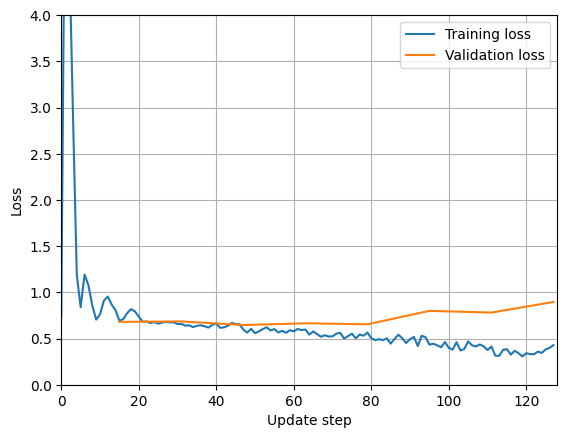

In [37]:
plt.figure()
plt.plot(range(len(history)), history, label='Training loss')
plt.plot(range(len(data_loader['train']) - 1, len(history), len(data_loader['train'])), validation_history, label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Update step')
plt.ylabel('Loss')
plt.xlim([0.0, len(history)])
plt.ylim([0.0, 4.0])
plt.grid()

##### Evaluation

In [38]:
# Set model in evaluation mode
model.eval()

SequenceClassification(
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (conv1d): Conv1d(300, 512, kernel_size=(5,), stride=(1,), padding=same)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_head): Linear(in_features=512, out_features=2, bias=True)
  (out_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (pool): AttentionAvgPooling(
    (qkv_attn): Conv1D()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

Validation set

In [39]:
#
split = 'validation'

# Accumulators for target labels and predictions
y_true = []
y_pred = []
y_proba = []

# Disable gradients
with torch.no_grad():
    # Iterate over validation batches
    for embeds, weights, lbl in tqdm(data_loader[split]):
        # Move input and output to target device
        embeds = embeds.to(device)
        weights = weights.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds, weights)
        # Get predictions as the index corresponding to the highest logit score
        pred_lbl = torch.argmax(logits, dim=-1)
        # Append predicted proba
        y_proba.append(logits.view(-1, len(le[task].classes_)).cpu().numpy())
        # Append predicted labels
        y_pred.append(pred_lbl.view(-1).cpu().numpy())
        # Append target labels
        y_true.append(lbl.view(-1).cpu().numpy())

# Concatenate all the vectors of target labels and predicted labels
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_proba = np.concatenate(y_proba, axis=0)
# Remove elements to ignore (the -100 labels)
mask = y_true == -100
y_true = y_true[~mask]
y_pred = y_pred[~mask]
y_proba = y_proba[~mask]

labels = np.unique(y_true)
mapping = np.zeros(len(le[task].classes_), dtype=int)
mapping[labels] = np.arange(len(labels))

y_true = mapping[y_true]
y_pred = mapping[y_pred]
y_proba = softmax(y_proba[:, labels], axis=1)[:, 1]

ids, counts = np.unique(y_true, return_counts=True)
weights = counts / np.sum(counts)

# 
accuracy = accuracy_score(y_true, y_pred)
precision_m, recall_m, fscore_m, support_m = precision_recall_fscore_support(y_true, y_pred, average='macro')
auc_m = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
precision_w, recall_w, fscore_w, support_w = precision_recall_fscore_support(y_true, y_pred, average='weighted')
auc_w = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
accuracy_sw = accuracy_score(y_true, y_pred, sample_weight=weights[y_true])
precision_sw, recall_sw, fscore_sw, support_sw = precision_recall_fscore_support(y_true, y_pred, average='weighted', sample_weight=weights[y_true])
auc_sw = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted', sample_weight=weights[y_true])
results.extend([
    {
        'corpus': corpus,
        'task': task,
        'embeddings': model_id,
        'split': split,
        'timestamp': timestamp,
        'metric': metric,
        'value': value
    }
    for metric, value in zip(
        CLS_METRICS, [
            accuracy, precision_m, recall_m, fscore_m, auc_m, 
            precision_w, recall_w, fscore_w, auc_w,
            accuracy_sw, precision_sw, recall_sw, fscore_sw, auc_sw
        ]
    )
])
# Finally compute classification report
print()
print(classification_report(y_true, y_pred, target_names=le[task].classes_[labels]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.27it/s]


              precision    recall  f1-score   support

    negative       0.74      0.45      0.56      1049
    positive       0.61      0.84      0.71      1076

    accuracy                           0.65      2125
   macro avg       0.68      0.65      0.64      2125
weighted avg       0.68      0.65      0.64      2125



Test set

In [40]:
#
split = 'test'

# Accumulators for target labels and predictions
y_true = []
y_pred = []
y_proba = []

# Disable gradients
with torch.no_grad():
    # Iterate over validation batches
    for embeds, weights, lbl in tqdm(data_loader[split]):
        # Move input and output to target device
        embeds = embeds.to(device)
        weights = weights.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds, weights)
        # Get predictions as the index corresponding to the highest logit score
        pred_lbl = torch.argmax(logits, dim=-1)
        # Append predicted proba
        y_proba.append(logits.view(-1, len(le[task].classes_)).cpu().numpy())
        # Append predicted labels
        y_pred.append(pred_lbl.view(-1).cpu().numpy())
        # Append target labels
        y_true.append(lbl.view(-1).cpu().numpy())

# Concatenate all the vectors of target labels and predicted labels
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_proba = np.concatenate(y_proba, axis=0)
# Remove elements to ignore (the -100 labels)
mask = y_true == -100
y_true = y_true[~mask]
y_pred = y_pred[~mask]
y_proba = y_proba[~mask]

labels = np.unique(y_true)
mapping = np.zeros(len(le[task].classes_), dtype=int)
mapping[labels] = np.arange(len(labels))

y_true = mapping[y_true]
y_pred = mapping[y_pred]
y_proba = softmax(y_proba[:, labels], axis=1)[:, 1]

ids, counts = np.unique(y_true, return_counts=True)
weights = counts / np.sum(counts)

# 
accuracy = accuracy_score(y_true, y_pred)
precision_m, recall_m, fscore_m, support_m = precision_recall_fscore_support(y_true, y_pred, average='macro')
auc_m = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
precision_w, recall_w, fscore_w, support_w = precision_recall_fscore_support(y_true, y_pred, average='weighted')
auc_w = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
accuracy_sw = accuracy_score(y_true, y_pred, sample_weight=weights[y_true])
precision_sw, recall_sw, fscore_sw, support_sw = precision_recall_fscore_support(y_true, y_pred, average='weighted', sample_weight=weights[y_true])
auc_sw = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted', sample_weight=weights[y_true])
results.extend([
    {
        'corpus': corpus,
        'task': task,
        'embeddings': model_id,
        'split': split,
        'timestamp': timestamp,
        'metric': metric,
        'value': value
    }
    for metric, value in zip(
        CLS_METRICS, [
            accuracy, precision_m, recall_m, fscore_m, auc_m, 
            precision_w, recall_w, fscore_w, auc_w,
            accuracy_sw, precision_sw, recall_sw, fscore_sw, auc_sw
        ]
    )
])
# Finally compute classification report
print()
print(classification_report(y_true, y_pred, target_names=le[task].classes_[labels]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.37it/s]


              precision    recall  f1-score   support

    negative       0.72      0.46      0.56       512
    positive       0.61      0.82      0.70       532

    accuracy                           0.65      1044
   macro avg       0.66      0.64      0.63      1044
weighted avg       0.66      0.65      0.63      1044



### STS

In [ ]:
corpus = 'STS'

In [ ]:
sts['train']._data[:3]

In [ ]:
embeddings_model.fit_sif_embedding([sample[key] for sample in sts['train'] for key in ['sequence_a', 'sequence_b']])

In [ ]:
from typing import Tuple, List, Set

class Conv1D(nn.Module):
    """
    1D-convolutional layer as defined by Radford et al. for OpenAI GPT (and also used in GPT-2).
    Basically works like a linear layer but the weights are transposed.
    Args:
        nf (:obj:`int`): The number of output features.
        nx (:obj:`int`): The number of input features.

    Thanks to Hugging Face for the implementation
    """

    def __init__(self, nf, nx):
        super().__init__()
        self.nf = nf
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(torch.zeros(nf))

    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(*size_out)
        return x


def find_pruneable_heads_and_indices(heads: List[int],
                                     n_heads: int,
                                     head_size: int,
                                     already_pruned_heads: Set[int]) -> Tuple[Set[int], torch.LongTensor]:
    """
    Finds the heads and their indices taking :obj:`already_pruned_heads` into account.
    Args:
        heads (:obj:`List[int]`): List of the indices of heads to prune.
        n_heads (:obj:`int`): The number of heads in the model.
        head_size (:obj:`int`): The size of each head.
        already_pruned_heads (:obj:`Set[int]`): A set of already pruned heads.
    Returns:
        :obj:`Tuple[Set[int], torch.LongTensor]`: A tuple with the remaining heads and their corresponding indices.


    Thanks to Hugging Face for the implementation
    """
    mask = torch.ones(n_heads, head_size)
    heads = set(heads) - already_pruned_heads  # Convert to set and remove already pruned heads
    for head in heads:
        # Compute how many pruned heads are before the head and move the index accordingly
        head = head - sum(1 if h < head else 0 for h in already_pruned_heads)
        mask[head] = 0
    mask = mask.view(-1).contiguous().eq(1)
    index: torch.LongTensor = torch.arange(len(mask))[mask].long()
    return heads, index


def prune_conv1d_layer(layer: Conv1D, index: torch.LongTensor, dim: int = 1) -> Conv1D:
    """
    Prune a Conv1D layer to keep only entries in index. A Conv1D work as a Linear layer (see e.g. BERT) but the weights
    are transposed.
    Used to remove heads.
    Args:
        layer (:class:`~transformers.modeling_utils.Conv1D`): The layer to prune.
        index (:obj:`torch.LongTensor`): The indices to keep in the layer.
        dim (:obj:`int`, `optional`, defaults to 1): The dimension on which to keep the indices.
    Returns:
        :class:`~transformers.modeling_utils.Conv1D`: The pruned layer as a new layer with :obj:`requires_grad=True`.

    Thanks to Hugging Face for the implementation
    """
    index = index.to(layer.weight.device)
    W = layer.weight.index_select(dim, index).clone().detach()
    if dim == 0:
        b = layer.bias.clone().detach()
    else:
        b = layer.bias[index].clone().detach()
    new_size = list(layer.weight.size())
    new_size[dim] = len(index)
    new_layer = Conv1D(new_size[1], new_size[0]).to(layer.weight.device)
    new_layer.weight.requires_grad = False
    new_layer.weight.copy_(W.contiguous())
    new_layer.weight.requires_grad = True
    new_layer.bias.requires_grad = False
    new_layer.bias.copy_(b.contiguous())
    new_layer.bias.requires_grad = True
    return new_layer


class AttentionAvgPooling(nn.Module):
    def __init__(self,
                 n_hidden: int = 512,
                 n_heads: int = 8,
                 max_positions: int = 1024,
                 p_dropout: float = 0.1,
                 scale_attn_weights: bool = True):
        super().__init__()

        self.embed_dim = n_hidden
        self.num_heads = n_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.split_size = self.embed_dim
        assert self.head_dim * self.num_heads == self.embed_dim, f"`embed_dim` must be divisible by num_heads " \
                                                                 f"(got `embed_dim`: {self.embed_dim} and " \
                                                                 f"`num_heads`: {self.num_heads})."

        self.scale_attn_weights = scale_attn_weights

        self.qkv_attn = Conv1D(3 * self.embed_dim, self.embed_dim)

        self.dropout = nn.Dropout(p_dropout)

        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(heads, self.num_heads, self.head_dim, self.pruned_heads)
        index_attn = torch.cat([index, index + self.split_size, index + (2 * self.split_size)])

        # Prune conv1d layers
        self.qkv_attn = prune_conv1d_layer(self.qkv_attn, index_attn, dim=1)

        # Update hyper params
        self.split_size = (self.split_size // self.num_heads) * (self.num_heads - len(heads))
        self.num_heads = self.num_heads - len(heads)
        self.pruned_heads = self.pruned_heads.union(heads)

    def _attn(self, query, key, value, attention_mask=None):
        attn_weights = torch.matmul(query, key.transpose(-1, -2))
        attn_weights = attn_weights / (float(value.size(-1)) ** 0.5)

        if attention_mask is not None:
            # Apply the attention mask
            attn_weights = attn_weights + attention_mask

        attn_weights = nn.Softmax(dim=-1)(attn_weights)
        attn_weights = self.dropout(attn_weights)

        attn_output = torch.matmul(attn_weights, value)

        return attn_output, attn_weights

    @staticmethod
    def _split_heads(tensor, num_heads, attn_head_size):
        new_shape = tensor.size()[:-1] + (num_heads, attn_head_size)
        tensor = tensor.view(*new_shape)
        return tensor.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

    @staticmethod
    def _merge_heads(tensor, num_heads, attn_head_size):
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attn_head_size,)
        return tensor.view(new_shape)

    def forward(self,
                hidden_states,
                attention_mask=None,
                return_attention_weights=False):

        query, key, value = self.qkv_attn(hidden_states).split(self.split_size, dim=2)

        # Query is averaged to obtain pooling
        query = self._split_heads(query, self.num_heads, self.head_dim).mean(-2, keepdims=True)
        key = self._split_heads(key, self.num_heads, self.head_dim)
        value = self._split_heads(value, self.num_heads, self.head_dim)

        if attention_mask is not None:
            attention_mask = (1.0 - attention_mask) * -1e+6
            attention_mask = attention_mask[:, None, None, :]

        attn_output, attn_weights = self._attn(query, key, value, attention_mask)

        attn_output = self._merge_heads(attn_output, self.num_heads, self.head_dim)

        if not return_attention_weights:
            return attn_output  # attention
        else:
            attn_weights = self._merge_heads(attn_weights, self.num_heads, self.head_dim)
            return attn_output, attn_weights


# class GPT2Attention(nn.Module):
# https://github.com/huggingface/transformers/blob/master/src/transformers/models/gpt2/modeling_gpt2.py


class SequenceEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size: int = 512, kernel_size: int = 5):
        super().__init__()
        self.norm = nn.LayerNorm(input_size)
        self.conv1d = nn.Conv1d(input_size, hidden_size, kernel_size, padding='same')
        self.dropout = nn.Dropout(0.1)
        self.out_head = nn.Linear(hidden_size, hidden_size)
        ##
        self.norm = nn.LayerNorm(hidden_size)
        self.out_norm = nn.LayerNorm(hidden_size)
        self.pool = AttentionAvgPooling()
        
    def forward(self, x, w):
        # 
        x = self.dropout(x)
        #
        h = self.conv1d(x.transpose(-1, -2)).transpose(-1, -2)  # self.norm(x).transpose(-1, -2)
        ##
        h = self.norm(h)
        # Non-linear activation
        h = F.gelu(h)
        
        # Dropout
        h = self.dropout(h)
        # Weighted sum
        # h = torch.einsum('btd,bt->bd', h, w)
        # Apply last linear projection
        # h = self.out_head(h)
        ##
        h = self.pool(h, w)
        h = self.out_norm(h)

        return h

In [ ]:
mms = sts['train'].get_label_transformer()
mms

In [ ]:
task = 'similarity_score'

In [ ]:
model = SequenceEmbedding(300)    
model = model.to(device)
model

In [ ]:
lr = 0.001
batch_size = 512
n_epochs = 64
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=0.2)

In [ ]:
def collate(mini_batch):
    # Tokenise sequences 
    sequences_a = embeddings_model.tokenise([sample['sequence_a'] for sample in mini_batch])
    sequences_b = embeddings_model.tokenise([sample['sequence_b'] for sample in mini_batch])
    # Get the length of the longest sentence
    max_sequence_len_a = max(len(sample) for sample in sequences_a)
    max_sequence_len_b = max(len(sample) for sample in sequences_b)
    # Create an input tensor with all zero values
    input_embeds_a = np.zeros((len(mini_batch), max_sequence_len_a, 300))
    input_embeds_b = np.zeros((len(mini_batch), max_sequence_len_b, 300))
    # Create weights tensor with all zero values
    token_weights_a = np.zeros((len(mini_batch), max_sequence_len_a))
    valid_mask_a = np.zeros((len(mini_batch), max_sequence_len_a))
    token_weights_b = np.zeros((len(mini_batch), max_sequence_len_b))
    valid_mask_b = np.zeros((len(mini_batch), max_sequence_len_b))
    # Create a target output matrix with all -100 (PyTorch ignores this value by default)
    output_score = np.zeros((len(mini_batch), 1))
    # Fill the tensor and the matrix
    for i, _ in enumerate(mini_batch):
        for j, token in enumerate(sequences_a[i]):
            # Manage missing tokens in vocabulary
            input_embeds_a[i, j] = embeddings_model[token.lower()]
        token_weights_a[i, :len(sequences_a[i])] = embeddings_model.sif_embedding_model.word_weights[embeddings_model.encode(sequences_a[i], backend='numpy')]
        valid_mask_a[i, :len(sequences_a[i])] = 1.0
        for j, token in enumerate(sequences_b[i]):
            # Manage missing tokens in vocabulary
            input_embeds_b[i, j] = embeddings_model[token.lower()]
        token_weights_b[i, :len(sequences_b[i])] = embeddings_model.sif_embedding_model.word_weights[embeddings_model.encode(sequences_b[i], backend='numpy')]
        valid_mask_b[i, :len(sequences_b[i])] = 1.0
        output_score[i] = mms[task].transform([[mini_batch[i][task]]])[0]
    # Convert to PyTorch tensor
    input_embeds_a = torch.tensor(input_embeds_a, dtype=torch.float, device=device)
    token_weights_a = torch.tensor(token_weights_a, dtype=torch.float, device=device)
    valid_mask_a = torch.tensor(valid_mask_a, dtype=torch.float, device=device)
    input_embeds_b = torch.tensor(input_embeds_b, dtype=torch.float, device=device)
    token_weights_b = torch.tensor(token_weights_b, dtype=torch.float, device=device)
    valid_mask_b = torch.tensor(valid_mask_b, dtype=torch.float, device=device)
    output_score = torch.tensor(output_score, dtype=torch.float, device=device)

    # return input_embeds_a, token_weights_a, input_embeds_b, token_weights_b, output_score
    return input_embeds_a, valid_mask_a, input_embeds_b, valid_mask_b, output_score

In [ ]:
data_loader = {
    split: torch.utils.data.DataLoader(
        data, batch_size=batch_size, collate_fn=collate, shuffle=split == 'train'
    )
    for split, data in sts.items()
}

##### Training

In [ ]:
path = os.path.join('../experiments/contextual/', f'{model_id}_{corpus}_{task}_{datetime.now()}.ckpt')

# Set model in training mode
model.train()

# Accumulator of loss
history = []
validation_history = []
best_validation_loss = torch.tensor(float('inf'), device=device)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, steps_per_epoch=len(data_loader['train']), epochs=n_epochs, anneal_strategy='linear', pct_start=0.05)

estop_counter = 0

# Iterate over epochs
for i in range(n_epochs):
    print(f"Starting epoch {i + 1}/{n_epochs}")
    # Iterate over training batches
    for embeds_a, weights_a, embeds_b, weights_b, score in tqdm(data_loader['train']):
        # Zero your gradients for every batch!
        optimizer.zero_grad()
        # Move input and output to target device
        embeds_a = embeds_a.to(device)
        weights_a = weights_a.to(device)
        embeds_b = embeds_b.to(device)
        weights_b = weights_b.to(device)
        score = score.to(device)
        # Compute logits 
        embeds_a = model(embeds_a, weights_a)
        embeds_b = model(embeds_b, weights_b)
        logits = torch.sum(embeds_a.squeeze() * embeds_b.squeeze(), dim=1, keepdims=True)
        # Compute loss
        ## loss = F.binary_cross_entropy_with_logits(logits, score)
        loss = F.mse_loss(F.cosine_similarity(embeds_a, embeds_b, dim=-1), score)
        # Compute gradients
        loss.backward()
        # Update weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        # scheduler.step()
        # Save loss
        history.append(loss.detach())
    # Disable gradients
    with torch.no_grad():
        print(f"Starting validation epoch {i + 1}/{n_epochs}")
        # Set in evaluation mode
        model.eval()
        # Init validation loss accumulator
        loss = []
        # Iterate over validation batches
        for embeds_a, weights_a, embeds_b, weights_b, score in tqdm(data_loader['train']):
            # Zero your gradients for every batch!
            optimizer.zero_grad()
            # Move input and output to target device
            embeds_a = embeds_a.to(device)
            weights_a = weights_a.to(device)
            embeds_b = embeds_b.to(device)
            weights_b = weights_b.to(device)
            score = score.to(device)
            # Compute logits 
            embeds_a = model(embeds_a, weights_a)
            embeds_b = model(embeds_b, weights_b)
            logits = torch.sum(embeds_a.squeeze() * embeds_b.squeeze(), dim=1, keepdims=True)
            # Compute loss
            ## loss.append(F.binary_cross_entropy_with_logits(logits, score))
            loss.append(F.mse_loss(F.cosine_similarity(embeds_a, embeds_b, dim=-1), score))
        # Aggregate validation loss
        validation_history.append(torch.tensor(loss, device=device).mean())
        # Check if validation loss has improved
        if validation_history[-1] <= best_validation_loss:
            torch.save(model.state_dict(), path)
            best_validation_loss = validation_history[-1]
            estop_counter = 0
        else:
            estop_counter += 1
        # Restore training mode
        model.train()
    if estop_counter >= 5:
        break

# Restore best weights
if os.path.exists(path):
    model.load_state_dict(torch.load(path))

history = [loss.cpu().item() for loss in history]
validation_history = [loss.cpu().item() for loss in validation_history]

In [ ]:
plt.figure()
plt.plot(range(len(history)), history, label='Training loss')
plt.plot(range(len(data_loader['train']) - 1, len(history), len(data_loader['train'])), validation_history, label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Update step')
plt.ylabel('Loss')
plt.xlim([0.0, len(history)])
plt.ylim([0.0, 1.0])
plt.grid()

##### Evaluation

In [ ]:
# Set model in evaluation mode
model.eval()

Validation set

In [ ]:
#
split = 'validation'

# Accumulators for target labels and predictions
y_true = []
y_pred = []

# Disable gradients
with torch.no_grad():
    # Iterate over validation batches
    for embeds_a, weights_a, embeds_b, weights_b, score in tqdm(data_loader[split]):
        # Move input and output to target device
        embeds_a = embeds_a.to(device)
        weights_a = weights_a.to(device)
        embeds_b = embeds_b.to(device)
        weights_b = weights_b.to(device)
        score = score.to(device)
        # Compute logits 
        embeds_a = model(embeds_a, weights_a)
        embeds_b = model(embeds_b, weights_b)
        logits = torch.sum(embeds_a.squeeze() * embeds_b.squeeze(), dim=1, keepdims=True)
        # Append predicted labels
        ## y_pred.append(F.sigmoid(logits).view(-1).cpu().numpy())
        y_pred.append(F.cosine_similarity(embeds_a, embeds_b, dim=-1).view(-1).cpu().numpy())
        # Append target labels
        y_true.append(score.view(-1).cpu().numpy())

# Concatenate all the vectors of target labels and predicted labels
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# 
spearman_corr = spearmanr(y_true, y_pred)
pearson_corr = pearsonr(y_true, y_pred)

results.extend([
    {
        'corpus': corpus,
        'task': task,
        'embeddings': model_id,
        'split': split,
        'timestamp': timestamp,
        'metric': metric,
        'value': value
    }
    for metric, value in zip(
        REG_METRICS, [pearson_corr.correlation, pearson_corr.pvalue, spearman_corr.correlation, spearman_corr.pvalue]
    )
])

print(pearson_corr)
print(spearman_corr)

Test set

In [ ]:
#
split = 'test'

# Accumulators for target labels and predictions
y_true = []
y_pred = []

# Disable gradients
with torch.no_grad():
    # Iterate over validation batches
    for embeds_a, weights_a, embeds_b, weights_b, score in tqdm(data_loader[split]):
        # Move input and output to target device
        embeds_a = embeds_a.to(device)
        weights_a = weights_a.to(device)
        embeds_b = embeds_b.to(device)
        weights_b = weights_b.to(device)
        score = score.to(device)
        # Compute logits 
        embeds_a = model(embeds_a, weights_a)
        embeds_b = model(embeds_b, weights_b)
        logits = torch.sum(embeds_a.squeeze() * embeds_b.squeeze(), dim=1, keepdims=True)
        # Append predicted labels
        ## y_pred.append(F.sigmoid(logits).view(-1).cpu().numpy())
        y_pred.append(F.cosine_similarity(embeds_a, embeds_b, dim=-1).view(-1).cpu().numpy())
        # Append target labels
        y_true.append(score.view(-1).cpu().numpy())

# Concatenate all the vectors of target labels and predicted labels
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# 
spearman_corr = spearmanr(y_true, y_pred)
pearson_corr = pearsonr(y_true, y_pred)

results.extend([
    {
        'corpus': corpus,
        'task': task,
        'embeddings': model_id,
        'split': split,
        'timestamp': timestamp,
        'metric': metric,
        'value': value
    }
    for metric, value in zip(
        REG_METRICS, [pearson_corr.correlation, pearson_corr.pvalue, spearman_corr.correlation, spearman_corr.pvalue]
    )
])

print(pearson_corr)
print(spearman_corr)

### 20NG

In [41]:
corpus = '20NG'

In [42]:
ng['train']._data[:3]

[{'sequence': 'From: backon@vms.huji.ac.il\nSubject: Re: Go Hezbollah!!\nDistribution: world\nOrganization: The Hebrew University of Jerusalem\nLines: 23\n\nIn article <1993Apr14.125813.21737@ncsu.edu>, hernlem@chess.ncsu.edu (Brad Hernlem) writes:\n>\n> Lebanese resistance forces detonated a bomb under an Israeli occupation\n> patrol in Lebanese territory two days ago. Three soldiers were killed and\n> two wounded. In "retaliation", Israeli and Israeli-backed forces wounded\n> 8 civilians by bombarding several Lebanese villages. Ironically, the Israeli\n> government justifies its occupation in Lebanon by claiming that it is\n> necessary to prevent such bombardments of Israeli villages!!\n>\n> Congratulations to the brave men of the Lebanese resistance! With every\n> Israeli son that you place in the grave you are underlining the moral\n> bankruptcy of Israel\'s occupation and drawing attention to the Israeli\n> government\'s policy of reckless disregard for civilian life.\n>\n> Brad H

In [43]:
# embeddings_model.fit_sif_embedding([sample['sequence'] for sample in ng['train']])

In [44]:
from typing import Tuple, List, Set

class Conv1D(nn.Module):
    """
    1D-convolutional layer as defined by Radford et al. for OpenAI GPT (and also used in GPT-2).
    Basically works like a linear layer but the weights are transposed.
    Args:
        nf (:obj:`int`): The number of output features.
        nx (:obj:`int`): The number of input features.

    Thanks to Hugging Face for the implementation
    """

    def __init__(self, nf, nx):
        super().__init__()
        self.nf = nf
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(torch.zeros(nf))

    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(*size_out)
        return x


def find_pruneable_heads_and_indices(heads: List[int],
                                     n_heads: int,
                                     head_size: int,
                                     already_pruned_heads: Set[int]) -> Tuple[Set[int], torch.LongTensor]:
    """
    Finds the heads and their indices taking :obj:`already_pruned_heads` into account.
    Args:
        heads (:obj:`List[int]`): List of the indices of heads to prune.
        n_heads (:obj:`int`): The number of heads in the model.
        head_size (:obj:`int`): The size of each head.
        already_pruned_heads (:obj:`Set[int]`): A set of already pruned heads.
    Returns:
        :obj:`Tuple[Set[int], torch.LongTensor]`: A tuple with the remaining heads and their corresponding indices.


    Thanks to Hugging Face for the implementation
    """
    mask = torch.ones(n_heads, head_size)
    heads = set(heads) - already_pruned_heads  # Convert to set and remove already pruned heads
    for head in heads:
        # Compute how many pruned heads are before the head and move the index accordingly
        head = head - sum(1 if h < head else 0 for h in already_pruned_heads)
        mask[head] = 0
    mask = mask.view(-1).contiguous().eq(1)
    index: torch.LongTensor = torch.arange(len(mask))[mask].long()
    return heads, index


def prune_conv1d_layer(layer: Conv1D, index: torch.LongTensor, dim: int = 1) -> Conv1D:
    """
    Prune a Conv1D layer to keep only entries in index. A Conv1D work as a Linear layer (see e.g. BERT) but the weights
    are transposed.
    Used to remove heads.
    Args:
        layer (:class:`~transformers.modeling_utils.Conv1D`): The layer to prune.
        index (:obj:`torch.LongTensor`): The indices to keep in the layer.
        dim (:obj:`int`, `optional`, defaults to 1): The dimension on which to keep the indices.
    Returns:
        :class:`~transformers.modeling_utils.Conv1D`: The pruned layer as a new layer with :obj:`requires_grad=True`.

    Thanks to Hugging Face for the implementation
    """
    index = index.to(layer.weight.device)
    W = layer.weight.index_select(dim, index).clone().detach()
    if dim == 0:
        b = layer.bias.clone().detach()
    else:
        b = layer.bias[index].clone().detach()
    new_size = list(layer.weight.size())
    new_size[dim] = len(index)
    new_layer = Conv1D(new_size[1], new_size[0]).to(layer.weight.device)
    new_layer.weight.requires_grad = False
    new_layer.weight.copy_(W.contiguous())
    new_layer.weight.requires_grad = True
    new_layer.bias.requires_grad = False
    new_layer.bias.copy_(b.contiguous())
    new_layer.bias.requires_grad = True
    return new_layer


class AttentionAvgPooling(nn.Module):
    def __init__(self,
                 n_hidden: int = 512,
                 n_heads: int = 8,
                 max_positions: int = 1024,
                 p_dropout: float = 0.1,
                 scale_attn_weights: bool = True):
        super().__init__()

        self.embed_dim = n_hidden
        self.num_heads = n_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.split_size = self.embed_dim
        assert self.head_dim * self.num_heads == self.embed_dim, f"`embed_dim` must be divisible by num_heads " \
                                                                 f"(got `embed_dim`: {self.embed_dim} and " \
                                                                 f"`num_heads`: {self.num_heads})."

        self.scale_attn_weights = scale_attn_weights

        self.qkv_attn = Conv1D(3 * self.embed_dim, self.embed_dim)

        self.dropout = nn.Dropout(p_dropout)

        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(heads, self.num_heads, self.head_dim, self.pruned_heads)
        index_attn = torch.cat([index, index + self.split_size, index + (2 * self.split_size)])

        # Prune conv1d layers
        self.qkv_attn = prune_conv1d_layer(self.qkv_attn, index_attn, dim=1)

        # Update hyper params
        self.split_size = (self.split_size // self.num_heads) * (self.num_heads - len(heads))
        self.num_heads = self.num_heads - len(heads)
        self.pruned_heads = self.pruned_heads.union(heads)

    def _attn(self, query, key, value, attention_mask=None):
        attn_weights = torch.matmul(query, key.transpose(-1, -2))
        attn_weights = attn_weights / (float(value.size(-1)) ** 0.5)

        if attention_mask is not None:
            # Apply the attention mask
            attn_weights = attn_weights + attention_mask

        attn_weights = nn.Softmax(dim=-1)(attn_weights)
        attn_weights = self.dropout(attn_weights)

        attn_output = torch.matmul(attn_weights, value)

        return attn_output, attn_weights

    @staticmethod
    def _split_heads(tensor, num_heads, attn_head_size):
        new_shape = tensor.size()[:-1] + (num_heads, attn_head_size)
        tensor = tensor.view(*new_shape)
        return tensor.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

    @staticmethod
    def _merge_heads(tensor, num_heads, attn_head_size):
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attn_head_size,)
        return tensor.view(new_shape)

    def forward(self,
                hidden_states,
                attention_mask=None,
                return_attention_weights=False):

        query, key, value = self.qkv_attn(hidden_states).split(self.split_size, dim=2)

        # Query is averaged to obtain pooling
        query = self._split_heads(query, self.num_heads, self.head_dim).mean(-2, keepdims=True)
        key = self._split_heads(key, self.num_heads, self.head_dim)
        value = self._split_heads(value, self.num_heads, self.head_dim)

        if attention_mask is not None:
            attention_mask = (1.0 - attention_mask) * -1e+6
            attention_mask = attention_mask[:, None, None, :]

        attn_output, attn_weights = self._attn(query, key, value, attention_mask)

        attn_output = self._merge_heads(attn_output, self.num_heads, self.head_dim)

        if not return_attention_weights:
            return attn_output  # attention
        else:
            attn_weights = self._merge_heads(attn_weights, self.num_heads, self.head_dim)
            return attn_output, attn_weights


# class GPT2Attention(nn.Module):
# https://github.com/huggingface/transformers/blob/master/src/transformers/models/gpt2/modeling_gpt2.py


class SequenceClassification(nn.Module):
    def __init__(self, input_size, output_size, hidden_size: int = 512, kernel_size: int = 5):
        super().__init__()
        self.norm = nn.LayerNorm(input_size)
        self.conv1d = nn.Conv1d(input_size, hidden_size, kernel_size, padding='same')
        self.dropout = nn.Dropout(0.1)
        self.out_head = nn.Linear(hidden_size, output_size)
        ##
        self.norm = nn.LayerNorm(hidden_size)
        self.out_norm = nn.LayerNorm(hidden_size)
        self.pool = AttentionAvgPooling()
        
    def forward(self, x, w):
        # 
        x = self.dropout(x)
        #
        h = self.conv1d(x.transpose(-1, -2)).transpose(-1, -2)  # self.norm(x).transpose(-1, -2)
        ##
        h = self.norm(h)
        # Non-linear activation
        h = F.gelu(h)
        
        # Dropout
        h = self.dropout(h)
        # Weighted sum
        # h = torch.einsum('btd,bt->bd', h, w)
        # Apply last linear projection
        # h = self.out_head(h)
        ##
        h = self.pool(h, w)
        h = self.out_norm(h)
        y = self.out_head(h)

        return y

'''
class SequenceClassification(nn.Module):
    def __init__(self, input_size, output_size, hidden_size: int = 512, kernel_size: int = 5):
        super().__init__()
        self.norm = nn.LayerNorm(input_size)
        self.conv1d = nn.Conv1d(input_size, hidden_size, kernel_size, padding='same')
        self.dropout = nn.Dropout(0.1)
        self.cls_head = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, w):
        # 
        x = self.dropout(x)
        #
        h = self.conv1d(self.norm(x).transpose(-1, -2))
        # Non-linear activation
        h = F.gelu(h)
        # Dropout
        h = self.dropout(h)
        # Weighted sum
        h = torch.einsum('btd,bt->bd', h.transpose(-1, -2), w)
        # Apply last linear projection
        y = self.cls_head(h)

        return y
'''

"\nclass SequenceClassification(nn.Module):\n    def __init__(self, input_size, output_size, hidden_size: int = 512, kernel_size: int = 5):\n        super().__init__()\n        self.norm = nn.LayerNorm(input_size)\n        self.conv1d = nn.Conv1d(input_size, hidden_size, kernel_size, padding='same')\n        self.dropout = nn.Dropout(0.1)\n        self.cls_head = nn.Linear(hidden_size, output_size)\n        \n    def forward(self, x, w):\n        # \n        x = self.dropout(x)\n        #\n        h = self.conv1d(self.norm(x).transpose(-1, -2))\n        # Non-linear activation\n        h = F.gelu(h)\n        # Dropout\n        h = self.dropout(h)\n        # Weighted sum\n        h = torch.einsum('btd,bt->bd', h.transpose(-1, -2), w)\n        # Apply last linear projection\n        y = self.cls_head(h)\n\n        return y\n"

In [45]:
le = ng['train'].get_label_transformer()
for label, le_ in le.items():
    print(label, le_.classes_)

newsgroup ['alt.atheism' 'comp.graphics' 'comp.os.ms-windows.misc'
 'comp.sys.ibm.pc.hardware' 'comp.sys.mac.hardware' 'comp.windows.x'
 'misc.forsale' 'rec.autos' 'rec.motorcycles' 'rec.sport.baseball'
 'rec.sport.hockey' 'sci.crypt' 'sci.electronics' 'sci.med' 'sci.space'
 'soc.religion.christian' 'talk.politics.guns' 'talk.politics.mideast'
 'talk.politics.misc' 'talk.religion.misc']


In [46]:
lw = {label: lw_.to(device) for label, lw_ in ng['train'].get_label_weights().items()}
for label, lw_ in lw.items():
    print(label, lw_)

newsgroup tensor([1.2582, 1.0595, 1.0266, 1.0475, 1.0793, 1.0668, 1.0198, 1.0619, 1.0619,
        1.0312, 1.0289, 1.0523, 1.0428, 1.0000, 1.0547, 1.0428, 1.1517, 1.1024,
        1.2969, 1.5966], device='cuda:0')


In [47]:
task = 'newsgroup'

In [48]:
model = SequenceClassification(300, len(le[task].classes_))    
model = model.to(device)
model

SequenceClassification(
  (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (conv1d): Conv1d(300, 512, kernel_size=(5,), stride=(1,), padding=same)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_head): Linear(in_features=512, out_features=20, bias=True)
  (out_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (pool): AttentionAvgPooling(
    (qkv_attn): Conv1D()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [49]:
lr = 0.001
batch_size = 8
n_epochs = 64
accumulation_steps = 64
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=0.2)
# optimizer = torch.optim.RMSprop(params=model.parameters(), lr=lr)

In [50]:
def collate(mini_batch):
    # Tokenise sequences 
    sequences = embeddings_model.tokenise([sample['sequence'] for sample in mini_batch])
    # Get the length of the longest sentence
    max_sequence_len = max(len(sample) for sample in sequences)
    # Create an input tensor with all zero values
    input_embeds = np.zeros((len(mini_batch), max_sequence_len, 300))
    # Create weights tensor with all zero values
    token_weights = np.zeros((len(mini_batch), max_sequence_len))
    valid_mask = np.zeros((len(mini_batch), max_sequence_len))
    # Create a target output matrix with all -100 (PyTorch ignores this value by default)
    output_lbl = np.full((len(mini_batch), 1), -100)
    # Fill the tensor and the matrix
    for i, sample in enumerate(sequences):
        for j, token in enumerate(sample):
            # Manage missing tokens in vocabulary
            input_embeds[i, j] = embeddings_model[token.lower()]
        token_weights[i, :len(sample)] = embeddings_model.sif_embedding_model.word_weights[embeddings_model.encode(sample, backend='numpy')]
        valid_mask[i, :len(sample)] = 1.0
        output_lbl[i] = le[task].transform([mini_batch[i][task]])[0]
    # Convert to PyTorch tensor
    input_embeds = torch.tensor(input_embeds, dtype=torch.float, device=device)
    token_weights = torch.tensor(token_weights, dtype=torch.float, device=device)
    valid_mask = torch.tensor(valid_mask, dtype=torch.float, device=device)
    output_lbl = torch.tensor(output_lbl, device=device)

    # return input_embeds, token_weights, output_lbl
    return input_embeds, valid_mask, output_lbl

In [51]:
data_loader = {
    split: torch.utils.data.DataLoader(
        data, batch_size=batch_size, collate_fn=collate, shuffle=split == 'train'
    )
    for split, data in ng.items()
}

##### Training

In [ ]:
path = os.path.join('../experiments/contextual/', f'{model_id}_{corpus}_{task}_{datetime.now()}.ckpt')

# Set model in training mode
model.train()

# Accumulator of loss
history = []
validation_history = []
best_validation_loss = torch.tensor(float('inf'), device=device)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, steps_per_epoch=len(data_loader['train']), epochs=n_epochs, anneal_strategy='linear', pct_start=0.05)

estop_counter = 0

# Iterate over epochs
for i in range(n_epochs):
    print(f"Starting epoch {i + 1}/{n_epochs}")
    # Iterate over training batches
    for j, (embeds, weights, lbl) in tqdm(enumerate(data_loader['train'])):
        # Zero your gradients for every batch!
        if j % accumulation_steps == 0:
            optimizer.zero_grad()
        # Move input and output to target device
        embeds = embeds.to(device)
        weights = weights.to(device)
        lbl = lbl.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds, weights)
        # Flatten logits to a shape (batch_size * max_sentence_len, n_classes)
        logits = logits.reshape(-1, len(le[task].classes_))
        # Flatten targets to a shape (batch_size * max_sentence_len)
        lbl = lbl.reshape(-1)
        # Compute loss
        loss = F.cross_entropy(logits, lbl) / accumulation_steps
        # Compute gradients
        loss.backward()
        # Update weights
        if j + 1 % accumulation_steps == 0 or j + 1 == len(data_loader['train']):
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        # scheduler.step()
        # Save loss
        history.append(loss)
    # Disable gradients
    with torch.no_grad():
        print(f"Starting validation epoch {i + 1}/{n_epochs}")
        # Set in evaluation mode
        model.eval()
        # Init validation loss accumulator
        loss = []
        # Iterate over validation batches
        for embeds, weights, lbl in tqdm(data_loader['validation']):
            # Move input and output to target device
            embeds = embeds.to(device)
            weights = weights.to(device)
            lbl = lbl.to(device)
            # Compute logits (i.e., softmax values before exponential normalisation)
            logits = model(embeds, weights)
            # Flatten logits to a shape (batch_size * max_sentence_len, n_classes)
            logits = logits.reshape(-1, len(le[task].classes_))
            # Flatten targets to a shape (batch_size * max_sentence_len)
            lbl = lbl.reshape(-1)
            # Compute loss
            loss.append(F.cross_entropy(logits, lbl))
        # Aggregate validation loss
        validation_history.append(torch.tensor(loss, device=device).mean())
        # Check if validation loss has improved
        if validation_history[-1] <= best_validation_loss:
            torch.save(model.state_dict(), path)
            best_validation_loss = validation_history[-1]
            estop_counter = 0
        else:
            estop_counter += 1
        # Restore training mode
        model.train()
    if estop_counter >= 5:
        break
        
# Restore best weights
if os.path.exists(path):
    model.load_state_dict(torch.load(path))

history = [loss.cpu().item() for loss in history]
validation_history = [loss.cpu().item() for loss in validation_history]

Starting epoch 1/64


3it [00:00, 26.28it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed c

Starting validation epoch 1/64


  0%|                                                                                                                                                                                    | 0/354 [00:00<?, ?it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
  2%|██▉                     

Starting epoch 2/64


5it [00:00, 44.47it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
10it [00:00, 44.77it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
33it [00:00, 52.86it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN

Starting validation epoch 2/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.35it/s]


Starting epoch 3/64


212it [00:06, 20.40it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
287it [00:08, 40.14it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
324it [00:09, 37.08it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_

Starting validation epoch 3/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.88it/s]


Starting epoch 4/64


44it [00:00, 45.05it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
468it [00:13, 34.74it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
830it [00:22, 48.90it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_P

Starting validation epoch 4/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.07it/s]


Starting epoch 5/64


11it [00:00, 23.29it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
166it [00:04, 45.26it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1058it [00:28, 52.12it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_

Starting validation epoch 5/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.31it/s]


Starting epoch 6/64


409it [00:10, 32.85it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1056it [00:28, 40.77it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 37.12it/s]


Starting validation epoch 6/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.98it/s]


Starting epoch 7/64


1061it [00:28, 37.05it/s]


Starting validation epoch 7/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.92it/s]


Starting epoch 8/64


786it [00:21, 34.45it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 37.35it/s]


Starting validation epoch 8/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.37it/s]


Starting epoch 9/64


1058it [00:28, 26.06it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 36.60it/s]


Starting validation epoch 9/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.30it/s]


Starting epoch 10/64


1061it [00:28, 37.46it/s]


Starting validation epoch 10/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.52it/s]


Starting epoch 11/64


1061it [00:28, 36.96it/s]


Starting validation epoch 11/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.01it/s]


Starting epoch 12/64


1061it [00:28, 36.95it/s]


Starting validation epoch 12/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.83it/s]


Starting epoch 13/64


1061it [00:28, 36.90it/s]


Starting validation epoch 13/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.28it/s]


Starting epoch 14/64


1060it [00:27, 43.83it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 37.79it/s]


Starting validation epoch 14/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.69it/s]


Starting epoch 15/64


1061it [00:28, 36.88it/s]


Starting validation epoch 15/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.96it/s]


Starting epoch 16/64


1061it [00:28, 37.08it/s]


Starting validation epoch 16/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.86it/s]


Starting epoch 17/64


1061it [00:28, 37.04it/s]


Starting validation epoch 17/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.22it/s]


Starting epoch 18/64


1058it [00:28, 46.75it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 37.47it/s]


Starting validation epoch 18/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.58it/s]


Starting epoch 19/64


1061it [00:28, 36.83it/s]


Starting validation epoch 19/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.67it/s]


Starting epoch 20/64


1061it [00:28, 37.62it/s]


Starting validation epoch 20/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.88it/s]


Starting epoch 21/64


1059it [00:28, 39.01it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 37.58it/s]


Starting validation epoch 21/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.32it/s]


Starting epoch 22/64


1061it [00:28, 37.40it/s]


Starting validation epoch 22/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.10it/s]


Starting epoch 23/64


1059it [00:28, 49.23it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 37.49it/s]


Starting validation epoch 23/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.30it/s]


Starting epoch 24/64


1057it [00:28, 42.57it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 36.74it/s]


Starting validation epoch 24/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.81it/s]


Starting epoch 25/64


1057it [00:28, 25.29it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:29, 36.54it/s]


Starting validation epoch 25/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.26it/s]


Starting epoch 26/64


1061it [00:28, 37.51it/s]


Starting validation epoch 26/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.06it/s]


Starting epoch 27/64


1060it [00:28, 46.57it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 37.43it/s]


Starting validation epoch 27/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.10it/s]


Starting epoch 28/64


1060it [00:28, 35.96it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 37.42it/s]


Starting validation epoch 28/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.09it/s]


Starting epoch 29/64


1061it [00:28, 37.19it/s]


Starting validation epoch 29/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.98it/s]


Starting epoch 30/64


1061it [00:28, 36.59it/s]


Starting validation epoch 30/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.75it/s]


Starting epoch 31/64


1058it [00:28, 38.75it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 36.97it/s]


Starting validation epoch 31/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.40it/s]


Starting epoch 32/64


1057it [00:28, 33.69it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 37.47it/s]


Starting validation epoch 32/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.51it/s]


Starting epoch 33/64


1061it [00:28, 37.60it/s]


Starting validation epoch 33/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.17it/s]


Starting epoch 34/64


1061it [00:28, 37.31it/s]


Starting validation epoch 34/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.60it/s]


Starting epoch 35/64


1061it [00:28, 36.81it/s]


Starting validation epoch 35/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 43.15it/s]


Starting epoch 36/64


1061it [00:28, 37.76it/s]


Starting validation epoch 36/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.98it/s]


Starting epoch 37/64


1061it [00:28, 37.76it/s]


Starting validation epoch 37/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 43.31it/s]


Starting epoch 38/64


1057it [00:27, 40.27it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 37.88it/s]


Starting validation epoch 38/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.30it/s]


Starting epoch 39/64


1058it [00:28, 36.25it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 37.46it/s]


Starting validation epoch 39/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 43.07it/s]


Starting epoch 40/64


1061it [00:29, 36.42it/s]


Starting validation epoch 40/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.83it/s]


Starting epoch 41/64


1061it [00:28, 36.97it/s]


Starting validation epoch 41/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.44it/s]


Starting epoch 42/64


1059it [00:29, 43.99it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:29, 36.32it/s]


Starting validation epoch 42/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.44it/s]


Starting epoch 43/64


1061it [00:28, 36.65it/s]


Starting validation epoch 43/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.28it/s]


Starting epoch 44/64


1061it [00:29, 35.62it/s]


Starting validation epoch 44/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 40.04it/s]


Starting epoch 45/64


1058it [00:29, 26.52it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:29, 36.33it/s]


Starting validation epoch 45/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 40.21it/s]


Starting epoch 46/64


1061it [00:30, 35.25it/s]


Starting validation epoch 46/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.73it/s]


Starting epoch 47/64


1057it [00:28, 48.30it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 36.92it/s]


Starting validation epoch 47/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.89it/s]


Starting epoch 48/64


1057it [00:29, 44.95it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:29, 36.10it/s]


Starting validation epoch 48/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.97it/s]


Starting epoch 49/64


1061it [00:28, 36.72it/s]


Starting validation epoch 49/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.88it/s]


Starting epoch 50/64


1061it [00:28, 36.93it/s]


Starting validation epoch 50/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.98it/s]


Starting epoch 51/64


1060it [00:28, 45.95it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 37.29it/s]


Starting validation epoch 51/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.63it/s]


Starting epoch 52/64


1061it [00:28, 36.93it/s]


Starting validation epoch 52/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.21it/s]


Starting epoch 53/64


1055it [00:29, 32.80it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:29, 35.87it/s]


Starting validation epoch 53/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 40.10it/s]


Starting epoch 54/64


1061it [00:28, 37.49it/s]


Starting validation epoch 54/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.51it/s]


Starting epoch 55/64


1056it [00:28, 51.40it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 37.61it/s]


Starting validation epoch 55/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 43.29it/s]


Starting epoch 56/64


1061it [00:28, 37.29it/s]


Starting validation epoch 56/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.53it/s]


Starting epoch 57/64


1054it [00:28, 39.72it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 36.93it/s]


Starting validation epoch 57/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.97it/s]


Starting epoch 58/64


1057it [00:28, 37.15it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 36.62it/s]


Starting validation epoch 58/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.92it/s]


Starting epoch 59/64


1060it [00:28, 45.91it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 36.77it/s]


Starting validation epoch 59/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.80it/s]


Starting epoch 60/64


1061it [00:28, 37.54it/s]


Starting validation epoch 60/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 43.34it/s]


Starting epoch 61/64


1055it [00:28, 36.33it/s]/home/vincenzo/anaconda3/envs/vstk/lib/python3.12/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
1061it [00:28, 37.36it/s]


Starting validation epoch 61/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 42.87it/s]


Starting epoch 62/64


1061it [00:28, 36.72it/s]


Starting validation epoch 62/64


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 354/354 [00:08<00:00, 41.97it/s]


Starting epoch 63/64


85it [00:02, 21.46it/s]

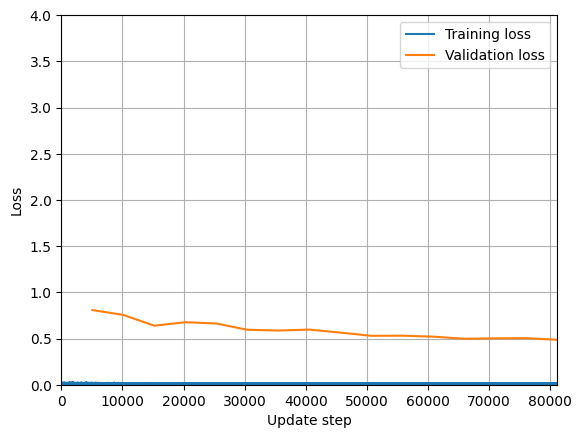

In [75]:
plt.figure()
plt.plot(range(len(history)), history, label='Training loss')
plt.plot(range(len(data_loader['train']) - 1, len(history), len(data_loader['train'])), validation_history, label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Update step')
plt.ylabel('Loss')
plt.xlim([0.0, len(history)])
plt.ylim([0.0, 4.0])
plt.grid()

##### Evaluation

In [ ]:
# Set model in evaluation mode
model.eval()

Validation set

In [ ]:
#
split = 'validation'

# Accumulators for target labels and predictions
y_true = []
y_pred = []
y_proba = []

# Disable gradients
with torch.no_grad():
    # Iterate over validation batches
    for embeds, weights, lbl in tqdm(data_loader[split]):
        # Move input and output to target device
        embeds = embeds.to(device)
        weights = weights.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds, weights)
        # Get predictions as the index corresponding to the highest logit score
        pred_lbl = torch.argmax(logits, dim=-1)
        # Append predicted proba
        y_proba.append(logits.view(-1, len(le[task].classes_)).cpu().numpy())
        # Append predicted labels
        y_pred.append(pred_lbl.view(-1).cpu().numpy())
        # Append target labels
        y_true.append(lbl.view(-1).cpu().numpy())

# Concatenate all the vectors of target labels and predicted labels
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_proba = np.concatenate(y_proba, axis=0)
# Remove elements to ignore (the -100 labels)
mask = y_true == -100
y_true = y_true[~mask]
y_pred = y_pred[~mask]
y_proba = y_proba[~mask]

labels = np.unique(y_true)
mapping = np.zeros(len(le[task].classes_), dtype=int)
mapping[labels] = np.arange(len(labels))

y_true = mapping[y_true]
y_pred = mapping[y_pred]
y_proba = softmax(y_proba[:, labels], axis=1)

ids, counts = np.unique(y_true, return_counts=True)
weights = counts / np.sum(counts)

# 
accuracy = accuracy_score(y_true, y_pred)
precision_m, recall_m, fscore_m, support_m = precision_recall_fscore_support(y_true, y_pred, average='macro')
auc_m = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
precision_w, recall_w, fscore_w, support_w = precision_recall_fscore_support(y_true, y_pred, average='weighted')
auc_w = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
accuracy_sw = accuracy_score(y_true, y_pred, sample_weight=weights[y_true])
precision_sw, recall_sw, fscore_sw, support_sw = precision_recall_fscore_support(y_true, y_pred, average='weighted', sample_weight=weights[y_true])
auc_sw = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted', sample_weight=weights[y_true])
results.extend([
    {
        'corpus': corpus,
        'task': task,
        'embeddings': model_id,
        'split': split,
        'timestamp': timestamp,
        'metric': metric,
        'value': value
    }
    for metric, value in zip(
        CLS_METRICS, [
            accuracy, precision_m, recall_m, fscore_m, auc_m, 
            precision_w, recall_w, fscore_w, auc_w,
            accuracy_sw, precision_sw, recall_sw, fscore_sw, auc_sw
        ]
    )
])
# Finally compute classification report
print()
print(classification_report(y_true, y_pred, target_names=le[task].classes_[labels]))

Test set

In [ ]:
#
split = 'test'

# Accumulators for target labels and predictions
y_true = []
y_pred = []
y_proba = []

# Disable gradients
with torch.no_grad():
    # Iterate over validation batches
    for embeds, weights, lbl in tqdm(data_loader[split]):
        # Move input and output to target device
        embeds = embeds.to(device)
        weights = weights.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds, weights)
        # Get predictions as the index corresponding to the highest logit score
        pred_lbl = torch.argmax(logits, dim=-1)
        # Append predicted proba
        y_proba.append(logits.view(-1, len(le[task].classes_)).cpu().numpy())
        # Append predicted labels
        y_pred.append(pred_lbl.view(-1).cpu().numpy())
        # Append target labels
        y_true.append(lbl.view(-1).cpu().numpy())

# Concatenate all the vectors of target labels and predicted labels
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_proba = np.concatenate(y_proba, axis=0)
# Remove elements to ignore (the -100 labels)
mask = y_true == -100
y_true = y_true[~mask]
y_pred = y_pred[~mask]
y_proba = y_proba[~mask]

labels = np.unique(y_true)
mapping = np.zeros(len(le[task].classes_), dtype=int)
mapping[labels] = np.arange(len(labels))

y_true = mapping[y_true]
y_pred = mapping[y_pred]
y_proba = softmax(y_proba[:, labels], axis=1)

ids, counts = np.unique(y_true, return_counts=True)
weights = counts / np.sum(counts)

# 
accuracy = accuracy_score(y_true, y_pred)
precision_m, recall_m, fscore_m, support_m = precision_recall_fscore_support(y_true, y_pred, average='macro')
auc_m = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
precision_w, recall_w, fscore_w, support_w = precision_recall_fscore_support(y_true, y_pred, average='weighted')
auc_w = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
accuracy_sw = accuracy_score(y_true, y_pred, sample_weight=weights[y_true])
precision_sw, recall_sw, fscore_sw, support_sw = precision_recall_fscore_support(y_true, y_pred, average='weighted', sample_weight=weights[y_true])
auc_sw = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted', sample_weight=weights[y_true])
results.extend([
    {
        'corpus': corpus,
        'task': task,
        'embeddings': model_id,
        'split': split,
        'timestamp': timestamp,
        'metric': metric,
        'value': value
    }
    for metric, value in zip(
        CLS_METRICS, [
            accuracy, precision_m, recall_m, fscore_m, auc_m, 
            precision_w, recall_w, fscore_w, auc_w,
            accuracy_sw, precision_sw, recall_sw, fscore_sw, auc_sw
        ]
    )
])
# Finally compute classification report
print()
print(classification_report(y_true, y_pred, target_names=le[task].classes_[labels]))

### WELFake

In [ ]:
corpus = 'WELFake'

In [ ]:
welfake['train']._data[:3]

In [ ]:
# embeddings_model.fit_sif_embedding([sample['sequence'] for sample in welfake['train']])

In [ ]:
from typing import Tuple, List, Set

class Conv1D(nn.Module):
    """
    1D-convolutional layer as defined by Radford et al. for OpenAI GPT (and also used in GPT-2).
    Basically works like a linear layer but the weights are transposed.
    Args:
        nf (:obj:`int`): The number of output features.
        nx (:obj:`int`): The number of input features.

    Thanks to Hugging Face for the implementation
    """

    def __init__(self, nf, nx):
        super().__init__()
        self.nf = nf
        w = torch.empty(nx, nf)
        nn.init.normal_(w, std=0.02)
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(torch.zeros(nf))

    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(*size_out)
        return x


def find_pruneable_heads_and_indices(heads: List[int],
                                     n_heads: int,
                                     head_size: int,
                                     already_pruned_heads: Set[int]) -> Tuple[Set[int], torch.LongTensor]:
    """
    Finds the heads and their indices taking :obj:`already_pruned_heads` into account.
    Args:
        heads (:obj:`List[int]`): List of the indices of heads to prune.
        n_heads (:obj:`int`): The number of heads in the model.
        head_size (:obj:`int`): The size of each head.
        already_pruned_heads (:obj:`Set[int]`): A set of already pruned heads.
    Returns:
        :obj:`Tuple[Set[int], torch.LongTensor]`: A tuple with the remaining heads and their corresponding indices.


    Thanks to Hugging Face for the implementation
    """
    mask = torch.ones(n_heads, head_size)
    heads = set(heads) - already_pruned_heads  # Convert to set and remove already pruned heads
    for head in heads:
        # Compute how many pruned heads are before the head and move the index accordingly
        head = head - sum(1 if h < head else 0 for h in already_pruned_heads)
        mask[head] = 0
    mask = mask.view(-1).contiguous().eq(1)
    index: torch.LongTensor = torch.arange(len(mask))[mask].long()
    return heads, index


def prune_conv1d_layer(layer: Conv1D, index: torch.LongTensor, dim: int = 1) -> Conv1D:
    """
    Prune a Conv1D layer to keep only entries in index. A Conv1D work as a Linear layer (see e.g. BERT) but the weights
    are transposed.
    Used to remove heads.
    Args:
        layer (:class:`~transformers.modeling_utils.Conv1D`): The layer to prune.
        index (:obj:`torch.LongTensor`): The indices to keep in the layer.
        dim (:obj:`int`, `optional`, defaults to 1): The dimension on which to keep the indices.
    Returns:
        :class:`~transformers.modeling_utils.Conv1D`: The pruned layer as a new layer with :obj:`requires_grad=True`.

    Thanks to Hugging Face for the implementation
    """
    index = index.to(layer.weight.device)
    W = layer.weight.index_select(dim, index).clone().detach()
    if dim == 0:
        b = layer.bias.clone().detach()
    else:
        b = layer.bias[index].clone().detach()
    new_size = list(layer.weight.size())
    new_size[dim] = len(index)
    new_layer = Conv1D(new_size[1], new_size[0]).to(layer.weight.device)
    new_layer.weight.requires_grad = False
    new_layer.weight.copy_(W.contiguous())
    new_layer.weight.requires_grad = True
    new_layer.bias.requires_grad = False
    new_layer.bias.copy_(b.contiguous())
    new_layer.bias.requires_grad = True
    return new_layer


class AttentionAvgPooling(nn.Module):
    def __init__(self,
                 n_hidden: int = 512,
                 n_heads: int = 8,
                 max_positions: int = 1024,
                 p_dropout: float = 0.1,
                 scale_attn_weights: bool = True):
        super().__init__()

        self.embed_dim = n_hidden
        self.num_heads = n_heads
        self.head_dim = self.embed_dim // self.num_heads
        self.split_size = self.embed_dim
        assert self.head_dim * self.num_heads == self.embed_dim, f"`embed_dim` must be divisible by num_heads " \
                                                                 f"(got `embed_dim`: {self.embed_dim} and " \
                                                                 f"`num_heads`: {self.num_heads})."

        self.scale_attn_weights = scale_attn_weights

        self.qkv_attn = Conv1D(3 * self.embed_dim, self.embed_dim)

        self.dropout = nn.Dropout(p_dropout)

        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(heads, self.num_heads, self.head_dim, self.pruned_heads)
        index_attn = torch.cat([index, index + self.split_size, index + (2 * self.split_size)])

        # Prune conv1d layers
        self.qkv_attn = prune_conv1d_layer(self.qkv_attn, index_attn, dim=1)

        # Update hyper params
        self.split_size = (self.split_size // self.num_heads) * (self.num_heads - len(heads))
        self.num_heads = self.num_heads - len(heads)
        self.pruned_heads = self.pruned_heads.union(heads)

    def _attn(self, query, key, value, attention_mask=None):
        attn_weights = torch.matmul(query, key.transpose(-1, -2))
        attn_weights = attn_weights / (float(value.size(-1)) ** 0.5)

        if attention_mask is not None:
            # Apply the attention mask
            attn_weights = attn_weights + attention_mask

        attn_weights = nn.Softmax(dim=-1)(attn_weights)
        attn_weights = self.dropout(attn_weights)

        attn_output = torch.matmul(attn_weights, value)

        return attn_output, attn_weights

    @staticmethod
    def _split_heads(tensor, num_heads, attn_head_size):
        new_shape = tensor.size()[:-1] + (num_heads, attn_head_size)
        tensor = tensor.view(*new_shape)
        return tensor.permute(0, 2, 1, 3)  # (batch, head, seq_length, head_features)

    @staticmethod
    def _merge_heads(tensor, num_heads, attn_head_size):
        tensor = tensor.permute(0, 2, 1, 3).contiguous()
        new_shape = tensor.size()[:-2] + (num_heads * attn_head_size,)
        return tensor.view(new_shape)

    def forward(self,
                hidden_states,
                attention_mask=None,
                return_attention_weights=False):

        query, key, value = self.qkv_attn(hidden_states).split(self.split_size, dim=2)

        # Query is averaged to obtain pooling
        query = self._split_heads(query, self.num_heads, self.head_dim).mean(-2, keepdims=True)
        key = self._split_heads(key, self.num_heads, self.head_dim)
        value = self._split_heads(value, self.num_heads, self.head_dim)

        if attention_mask is not None:
            attention_mask = (1.0 - attention_mask) * -1e+6
            attention_mask = attention_mask[:, None, None, :]

        attn_output, attn_weights = self._attn(query, key, value, attention_mask)

        attn_output = self._merge_heads(attn_output, self.num_heads, self.head_dim)

        if not return_attention_weights:
            return attn_output  # attention
        else:
            attn_weights = self._merge_heads(attn_weights, self.num_heads, self.head_dim)
            return attn_output, attn_weights


# class GPT2Attention(nn.Module):
# https://github.com/huggingface/transformers/blob/master/src/transformers/models/gpt2/modeling_gpt2.py


class SequenceClassification(nn.Module):
    def __init__(self, input_size, output_size, hidden_size: int = 512, kernel_size: int = 5):
        super().__init__()
        self.norm = nn.LayerNorm(input_size)
        self.conv1d = nn.Conv1d(input_size, hidden_size, kernel_size, padding='same')
        self.dropout = nn.Dropout(0.1)
        self.out_head = nn.Linear(hidden_size, output_size)
        ##
        self.norm = nn.LayerNorm(hidden_size)
        self.out_norm = nn.LayerNorm(hidden_size)
        self.pool = AttentionAvgPooling()
        
    def forward(self, x, w):
        # 
        x = self.dropout(x)
        #
        h = self.conv1d(x.transpose(-1, -2)).transpose(-1, -2)  # self.norm(x).transpose(-1, -2)
        ##
        h = self.norm(h)
        # Non-linear activation
        h = F.gelu(h)
        
        # Dropout
        h = self.dropout(h)
        # Weighted sum
        # h = torch.einsum('btd,bt->bd', h, w)
        # Apply last linear projection
        # h = self.out_head(h)
        ##
        h = self.pool(h, w)
        h = self.out_norm(h)
        y = self.out_head(h)

        return y

'''
class SequenceClassification(nn.Module):
    def __init__(self, input_size, output_size, hidden_size: int = 512, kernel_size: int = 5):
        super().__init__()
        self.norm = nn.LayerNorm(input_size)
        self.conv1d = nn.Conv1d(input_size, hidden_size, kernel_size, padding='same')
        self.dropout = nn.Dropout(0.1)
        self.cls_head = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, w):
        # 
        x = self.dropout(x)
        #
        h = self.conv1d(self.norm(x).transpose(-1, -2))
        # Non-linear activation
        h = F.gelu(h)
        # Dropout
        h = self.dropout(h)
        # Weighted sum
        h = torch.einsum('btd,bt->bd', h.transpose(-1, -2), w)
        # Apply last linear projection
        y = self.cls_head(h)

        return y
'''

In [ ]:
le = welfake['train'].get_label_transformer()
for label, le_ in le.items():
    print(label, le_.classes_)

In [ ]:
lw = {label: lw_.to(device) for label, lw_ in welfake['train'].get_label_weights().items()}
for label, lw_ in lw.items():
    print(label, lw_)

In [ ]:
task = 'fakenews'

In [ ]:
model = SequenceClassification(300, len(le[task].classes_))    
model = model.to(device)
model

In [ ]:
lr = 0.0001
batch_size = 8
n_epochs = 16
accumulation_steps = 64
optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=0.2)
# optimizer = torch.optim.RMSprop(params=model.parameters(), lr=lr)

In [ ]:
def collate(mini_batch):
    # Tokenise sequences 
    sequences = embeddings_model.tokenise([sample['sequence'] for sample in mini_batch])
    # Get the length of the longest sentence
    max_sequence_len = max(len(sample) for sample in sequences)
    # Create an input tensor with all zero values
    input_embeds = np.zeros((len(mini_batch), max_sequence_len, 300))
    # Create weights tensor with all zero values
    token_weights = np.zeros((len(mini_batch), max_sequence_len))
    valid_mask = np.zeros((len(mini_batch), max_sequence_len))
    # Create a target output matrix with all -100 (PyTorch ignores this value by default)
    output_lbl = np.full((len(mini_batch), 1), -100)
    # Fill the tensor and the matrix
    for i, sample in enumerate(sequences):
        for j, token in enumerate(sample):
            # Manage missing tokens in vocabulary
            input_embeds[i, j] = embeddings_model[token.lower()]
        token_weights[i, :len(sample)] = embeddings_model.sif_embedding_model.word_weights[embeddings_model.encode(sample, backend='numpy')]
        valid_mask[i, :len(sample)] = 1.0
        output_lbl[i] = le[task].transform([mini_batch[i][task]])[0]
    # Convert to PyTorch tensor
    input_embeds = torch.tensor(input_embeds, dtype=torch.float, device=device)
    token_weights = torch.tensor(token_weights, dtype=torch.float, device=device)
    valid_mask = torch.tensor(valid_mask, dtype=torch.float, device=device)
    output_lbl = torch.tensor(output_lbl, device=device)

    # return input_embeds, token_weights, output_lbl
    return input_embeds, valid_mask, output_lbl

In [ ]:
data_loader = {
    split: torch.utils.data.DataLoader(
        data, batch_size=batch_size, collate_fn=collate, shuffle=split == 'train'
    )
    for split, data in welfake.items()
}

##### Training

In [ ]:
path = os.path.join('../experiments/contextual/', f'{model_id}_{corpus}_{task}_{datetime.now()}.ckpt')

# Set model in training mode
model.train()

# Accumulator of loss
history = []
validation_history = []
best_validation_loss = torch.tensor(float('inf'), device=device)

# scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, lr, steps_per_epoch=len(data_loader['train']), epochs=n_epochs, anneal_strategy='linear', pct_start=0.05)

estop_counter = 0

# Iterate over epochs
for i in range(n_epochs):
    print(f"Starting epoch {i + 1}/{n_epochs}")
    # Iterate over training batches
    for j, (embeds, weights, lbl) in tqdm(enumerate(data_loader['train'])):
        # Zero your gradients for every batch!
        if j % accumulation_steps == 0:
            optimizer.zero_grad()
        # Move input and output to target device
        embeds = embeds.to(device)
        weights = weights.to(device)
        lbl = lbl.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds, weights)
        # Flatten logits to a shape (batch_size * max_sentence_len, n_classes)
        logits = logits.reshape(-1, len(le[task].classes_))
        # Flatten targets to a shape (batch_size * max_sentence_len)
        lbl = lbl.reshape(-1)
        # Compute loss
        loss = F.cross_entropy(logits, lbl) / accumulation_steps
        # Compute gradients
        loss.backward()
        # Update weights
        if j + 1 % accumulation_steps == 0 or j + 1 == len(data_loader['train']):
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
        # scheduler.step()
        # Save loss
        history.append(loss)
    # Disable gradients
    with torch.no_grad():
        print(f"Starting validation epoch {i + 1}/{n_epochs}")
        # Set in evaluation mode
        model.eval()
        # Init validation loss accumulator
        loss = []
        # Iterate over validation batches
        for embeds, weights, lbl in tqdm(data_loader['validation']):
            # Move input and output to target device
            embeds = embeds.to(device)
            weights = weights.to(device)
            lbl = lbl.to(device)
            # Compute logits (i.e., softmax values before exponential normalisation)
            logits = model(embeds, weights)
            # Flatten logits to a shape (batch_size * max_sentence_len, n_classes)
            logits = logits.reshape(-1, len(le[task].classes_))
            # Flatten targets to a shape (batch_size * max_sentence_len)
            lbl = lbl.reshape(-1)
            # Compute loss
            loss.append(F.cross_entropy(logits, lbl))
        # Aggregate validation loss
        validation_history.append(torch.tensor(loss, device=device).mean())
        # Check if validation loss has improved
        if validation_history[-1] <= best_validation_loss:
            torch.save(model.state_dict(), path)
            best_validation_loss = validation_history[-1]
            estop_counter = 0
        else:
            estop_counter += 1
        # Restore training mode
        model.train()
    if estop_counter >= 5:
        break
        
# Restore best weights
if os.path.exists(path):
    model.load_state_dict(torch.load(path))

history = [loss.cpu().item() for loss in history]
validation_history = [loss.cpu().item() for loss in validation_history]

In [ ]:
plt.figure()
plt.plot(range(len(history)), history, label='Training loss')
plt.plot(range(len(data_loader['train']) - 1, len(history), len(data_loader['train'])), validation_history, label='Validation loss')
plt.legend(loc='best')
plt.xlabel('Update step')
plt.ylabel('Loss')
plt.xlim([0.0, len(history)])
plt.ylim([0.0, 4.0])
plt.grid()

##### Evaluation

In [ ]:
# Set model in evaluation mode
model.eval()

Validation set

In [ ]:
#
split = 'validation'

# Accumulators for target labels and predictions
y_true = []
y_pred = []
y_proba = []

# Disable gradients
with torch.no_grad():
    # Iterate over validation batches
    for embeds, weights, lbl in tqdm(data_loader[split]):
        # Move input and output to target device
        embeds = embeds.to(device)
        weights = weights.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds, weights)
        # Get predictions as the index corresponding to the highest logit score
        pred_lbl = torch.argmax(logits, dim=-1)
        # Append predicted proba
        y_proba.append(logits.view(-1, len(le[task].classes_)).cpu().numpy())
        # Append predicted labels
        y_pred.append(pred_lbl.view(-1).cpu().numpy())
        # Append target labels
        y_true.append(lbl.view(-1).cpu().numpy())

# Concatenate all the vectors of target labels and predicted labels
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_proba = np.concatenate(y_proba, axis=0)
# Remove elements to ignore (the -100 labels)
mask = y_true == -100
y_true = y_true[~mask]
y_pred = y_pred[~mask]
y_proba = y_proba[~mask]

labels = np.unique(y_true)
mapping = np.zeros(len(le[task].classes_), dtype=int)
mapping[labels] = np.arange(len(labels))

y_true = mapping[y_true]
y_pred = mapping[y_pred]
y_proba = softmax(y_proba[:, labels], axis=1)[:, 1]

ids, counts = np.unique(y_true, return_counts=True)
weights = counts / np.sum(counts)

# 
accuracy = accuracy_score(y_true, y_pred)
precision_m, recall_m, fscore_m, support_m = precision_recall_fscore_support(y_true, y_pred, average='macro')
auc_m = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
precision_w, recall_w, fscore_w, support_w = precision_recall_fscore_support(y_true, y_pred, average='weighted')
auc_w = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
accuracy_sw = accuracy_score(y_true, y_pred, sample_weight=weights[y_true])
precision_sw, recall_sw, fscore_sw, support_sw = precision_recall_fscore_support(y_true, y_pred, average='weighted', sample_weight=weights[y_true])
auc_sw = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted', sample_weight=weights[y_true])
results.extend([
    {
        'corpus': corpus,
        'task': task,
        'embeddings': model_id,
        'split': split,
        'timestamp': timestamp,
        'metric': metric,
        'value': value
    }
    for metric, value in zip(
        CLS_METRICS, [
            accuracy, precision_m, recall_m, fscore_m, auc_m, 
            precision_w, recall_w, fscore_w, auc_w,
            accuracy_sw, precision_sw, recall_sw, fscore_sw, auc_sw
        ]
    )
])
# Finally compute classification report
print()
print(classification_report(y_true, y_pred, target_names=le[task].classes_[labels]))

Test set

In [ ]:
#
split = 'test'

# Accumulators for target labels and predictions
y_true = []
y_pred = []
y_proba = []

# Disable gradients
with torch.no_grad():
    # Iterate over validation batches
    for embeds, weights, lbl in tqdm(data_loader[split]):
        # Move input and output to target device
        embeds = embeds.to(device)
        weights = weights.to(device)
        # Compute logits (i.e., softmax values before exponential normalisation)
        logits = model(embeds, weights)
        # Get predictions as the index corresponding to the highest logit score
        pred_lbl = torch.argmax(logits, dim=-1)
        # Append predicted proba
        y_proba.append(logits.view(-1, len(le[task].classes_)).cpu().numpy())
        # Append predicted labels
        y_pred.append(pred_lbl.view(-1).cpu().numpy())
        # Append target labels
        y_true.append(lbl.view(-1).cpu().numpy())

# Concatenate all the vectors of target labels and predicted labels
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
y_proba = np.concatenate(y_proba, axis=0)
# Remove elements to ignore (the -100 labels)
mask = y_true == -100
y_true = y_true[~mask]
y_pred = y_pred[~mask]
y_proba = y_proba[~mask]

labels = np.unique(y_true)
mapping = np.zeros(len(le[task].classes_), dtype=int)
mapping[labels] = np.arange(len(labels))

y_true = mapping[y_true]
y_pred = mapping[y_pred]
y_proba = softmax(y_proba[:, labels], axis=1)[:, 1]

ids, counts = np.unique(y_true, return_counts=True)
weights = counts / np.sum(counts)

# 
accuracy = accuracy_score(y_true, y_pred)
precision_m, recall_m, fscore_m, support_m = precision_recall_fscore_support(y_true, y_pred, average='macro')
auc_m = roc_auc_score(y_true, y_proba, multi_class='ovr', average='macro')
precision_w, recall_w, fscore_w, support_w = precision_recall_fscore_support(y_true, y_pred, average='weighted')
auc_w = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
accuracy_sw = accuracy_score(y_true, y_pred, sample_weight=weights[y_true])
precision_sw, recall_sw, fscore_sw, support_sw = precision_recall_fscore_support(y_true, y_pred, average='weighted', sample_weight=weights[y_true])
auc_sw = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted', sample_weight=weights[y_true])
results.extend([
    {
        'corpus': corpus,
        'task': task,
        'embeddings': model_id,
        'split': split,
        'timestamp': timestamp,
        'metric': metric,
        'value': value
    }
    for metric, value in zip(
        CLS_METRICS, [
            accuracy, precision_m, recall_m, fscore_m, auc_m, 
            precision_w, recall_w, fscore_w, auc_w,
            accuracy_sw, precision_sw, recall_sw, fscore_sw, auc_sw
        ]
    )
])
# Finally compute classification report
print()
print(classification_report(y_true, y_pred, target_names=le[task].classes_[labels]))

## Results

In [ ]:
results_df = pd.DataFrame.from_dict(results)
results_df

In [ ]:
if os.path.exists(RESULTS_FILE_PATH):
    results_df.to_csv(RESULTS_FILE_PATH, mode='a', index=False, header=False)
else:
    results_df.to_csv(RESULTS_FILE_PATH, index=False)

In [ ]:
df = results_df[results_df['metric'].apply(lambda x: '(sample weight)' in x or 'corr.' in x)]
df

In [ ]:
df.groupby(['task', 'metric', 'split']).describe()